In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
data = pd.read_csv('df_combined.csv')

In [3]:
data.head()

,Classification_Size,Classification_Focus,Research_Intensity,Status,Academic_Reputation_Score,Employer_Reputation_Score,Faculty_Student_Score,Citations_Per_Faculty_Score,International_Faculty_Score,International_Student_Score,Overall_Score
0,M,CO,VH,B,100.0,100.0,100.0,99.9,100.0,96.1,100.0
1,L,FC,VH,B,100.0,100.0,100.0,99.4,99.6,72.7,98.7
2,L,FC,VH,B,100.0,100.0,98.3,99.9,96.5,75.2,98.4
3,S,CO,VH,B,99.5,85.4,100.0,100.0,93.4,89.2,97.7
4,L,FC,VH,A,100.0,100.0,100.0,78.3,97.4,97.7,95.6


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Classification_Size          2503 non-null   object 
 1   Classification_Focus         2503 non-null   object 
 2   Research_Intensity           2503 non-null   object 
 3   Status                       2503 non-null   object 
 4   Academic_Reputation_Score    2503 non-null   float64
 5   Employer_Reputation_Score    2503 non-null   float64
 6   Faculty_Student_Score        2503 non-null   float64
 7   Citations_Per_Faculty_Score  2503 non-null   float64
 8   International_Faculty_Score  2503 non-null   float64
 9   International_Student_Score  2503 non-null   float64
 10  Overall_Score                2503 non-null   float64
dtypes: float64(7), object(4)
memory usage: 215.2+ KB


In [5]:
cat_cols = data.select_dtypes(include = 'object')
num_cols= data.select_dtypes(exclude = 'object')

In [10]:
for col in cat_cols:
    print(col)
    print(np.unique(data[col]))

Classification_Size
['L' 'M' 'S' 'XL']
Classification_Focus
['CO' 'FC' 'FO' 'SP']
Research_Intensity
['HI' 'LO' 'MD' 'VH']
Status
['A' 'B' 'C']


In [7]:
encoding = {
    'Classification_Size' : {
        'XL' : 1,
        'L' : 2,
        'M' : 3,
        'S' : 4},
    'Research_Intensity' : {
        'VH' : 1,
        'HI' : 2,
        'MD' : 3,
        'LO' : 4},
    'Status' : {
        'A' : 1,
        'B' : 2,
        'C' : 3}
    }

In [11]:

encoded_cat = data.copy()
for col in cat_cols:
    if col not in list(encoding.keys()):
        val_dict = {v: i for i, v in enumerate(np.unique(data[col]))}
        print(val_dict)
    else:
        val_dict = encoding[col]
    encoded_cat[col] = encoded_cat[col].map(val_dict)

{'CO': 0, 'FC': 1, 'FO': 2, 'SP': 3}


In [9]:
encoded_cat

,Classification_Size,Classification_Focus,Research_Intensity,Status,Academic_Reputation_Score,Employer_Reputation_Score,Faculty_Student_Score,Citations_Per_Faculty_Score,International_Faculty_Score,International_Student_Score,Overall_Score
0,3,0,1,2,100.0,100.0,100.0,99.9,100.0,96.1,100.0
1,2,1,1,2,100.0,100.0,100.0,99.4,99.6,72.7,98.7
2,2,1,1,2,100.0,100.0,98.3,99.9,96.5,75.2,98.4
3,4,0,1,2,99.5,85.4,100.0,100.0,93.4,89.2,97.7
4,2,1,1,1,100.0,100.0,100.0,78.3,97.4,97.7,95.6
...,...,...,...,...,...,...,...,...,...,...,...
2498,2,2,1,1,34.9,25.1,28.8,24.6,13.4,47.4,9.1
2499,2,2,1,1,34.6,26.8,26.3,28.8,36.0,2.6,9.0
2500,1,2,1,1,31.9,21.7,34.4,18.9,44.1,7.2,9.0
2501,3,0,2,2,33.3,18.4,39.2,21.9,100.0,40.6,9.0


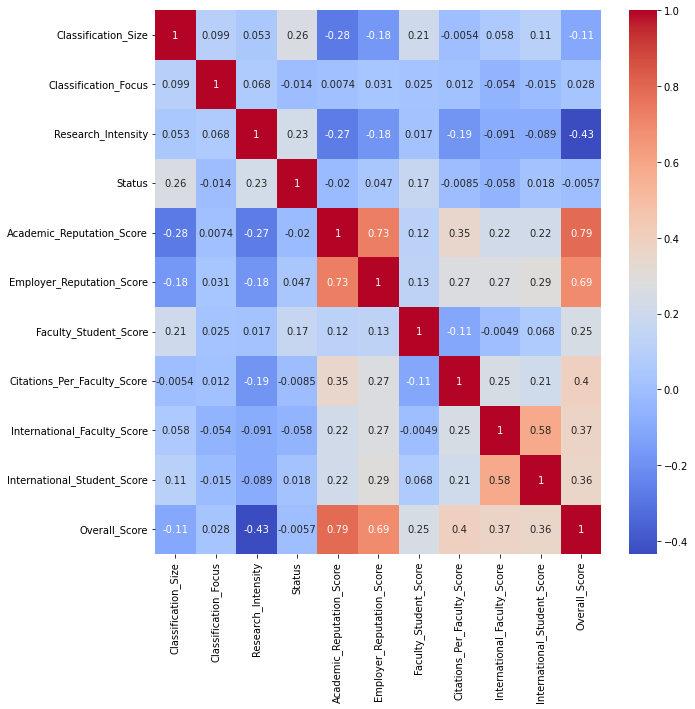

In [10]:
plt.figure(figsize=(10,10))
sns.heatmap(encoded_cat.corr(), cmap='coolwarm', annot=True)
plt.show()


In [13]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
gb = GradientBoostingRegressor()
rf = RandomForestRegressor()
xgb = xgboost.XGBRegressor()
cbt = CatBoostRegressor()
lass= Lasso()
ridge = Ridge()
models = [lr, dt, gb, rf, xgb, cbt, lass, ridge]
names =  ['lr', 'dt', 'gb', 'rf', 'xgb', 'cbt', 'lasso', 'ridge']

In [14]:
def evaluate(ytrue, ypred):
    mae = mean_absolute_error(ytrue, ypred)
    rmse = np.sqrt(mean_squared_error(ytrue, ypred))
    r2 = r2_score(ytrue, ypred)
    print('MAE -' , mae)
    print('RMSE -' , rmse)
    print('R2 -' , r2)
    return mae, rmse, r2

In [15]:
X = encoded_cat.drop(['Overall_Score'], axis = 1)
y = encoded_cat['Overall_Score']

In [17]:
for model in models:
    print(np.mean(np.absolute(cross_val_score(model, X, y, cv = 5, scoring = 'neg_mean_absolute_error'))))

9.648017603776728
7.150703872255488
6.68036524120844
5.9983503928143715
6.2895428933838415
Learning rate set to 0.045689
0:	learn: 19.0514165	total: 367ms	remaining: 6m 6s
1:	learn: 18.4267225	total: 379ms	remaining: 3m 9s
2:	learn: 17.8746132	total: 391ms	remaining: 2m 9s
3:	learn: 17.3279730	total: 402ms	remaining: 1m 40s
4:	learn: 16.7992607	total: 414ms	remaining: 1m 22s
5:	learn: 16.2739737	total: 426ms	remaining: 1m 10s
6:	learn: 15.7679360	total: 438ms	remaining: 1m 2s
7:	learn: 15.3181616	total: 449ms	remaining: 55.7s
8:	learn: 14.8940348	total: 461ms	remaining: 50.7s
9:	learn: 14.5041407	total: 474ms	remaining: 46.9s
10:	learn: 14.1127892	total: 486ms	remaining: 43.7s
11:	learn: 13.7323636	total: 498ms	remaining: 41s
12:	learn: 13.3751710	total: 509ms	remaining: 38.6s
13:	learn: 13.0735049	total: 520ms	remaining: 36.6s
14:	learn: 12.7515939	total: 532ms	remaining: 34.9s
15:	learn: 12.4098005	total: 546ms	remaining: 33.5s
16:	learn: 12.1507455	total: 563ms	remaining: 32.6s
17:	

159:	learn: 5.2455786	total: 2.64s	remaining: 13.9s
160:	learn: 5.2335566	total: 2.66s	remaining: 13.8s
161:	learn: 5.2270342	total: 2.67s	remaining: 13.8s
162:	learn: 5.2214794	total: 2.68s	remaining: 13.8s
163:	learn: 5.2157031	total: 2.69s	remaining: 13.7s
164:	learn: 5.2081320	total: 2.71s	remaining: 13.7s
165:	learn: 5.2014941	total: 2.72s	remaining: 13.7s
166:	learn: 5.1919699	total: 2.73s	remaining: 13.6s
167:	learn: 5.1796320	total: 2.75s	remaining: 13.6s
168:	learn: 5.1728418	total: 2.76s	remaining: 13.6s
169:	learn: 5.1642677	total: 2.77s	remaining: 13.5s
170:	learn: 5.1571822	total: 2.78s	remaining: 13.5s
171:	learn: 5.1464969	total: 2.79s	remaining: 13.4s
172:	learn: 5.1362245	total: 2.8s	remaining: 13.4s
173:	learn: 5.1309333	total: 2.81s	remaining: 13.3s
174:	learn: 5.1237700	total: 2.82s	remaining: 13.3s
175:	learn: 5.1179080	total: 2.83s	remaining: 13.3s
176:	learn: 5.1082074	total: 2.85s	remaining: 13.2s
177:	learn: 5.1044672	total: 2.86s	remaining: 13.2s
178:	learn: 5

320:	learn: 4.2367868	total: 4.54s	remaining: 9.61s
321:	learn: 4.2307771	total: 4.56s	remaining: 9.6s
322:	learn: 4.2265145	total: 4.57s	remaining: 9.58s
323:	learn: 4.2212852	total: 4.58s	remaining: 9.56s
324:	learn: 4.2173384	total: 4.59s	remaining: 9.54s
325:	learn: 4.2128782	total: 4.61s	remaining: 9.53s
326:	learn: 4.2051643	total: 4.62s	remaining: 9.52s
327:	learn: 4.2026635	total: 4.63s	remaining: 9.5s
328:	learn: 4.1956338	total: 4.65s	remaining: 9.48s
329:	learn: 4.1897291	total: 4.66s	remaining: 9.46s
330:	learn: 4.1862577	total: 4.67s	remaining: 9.44s
331:	learn: 4.1827212	total: 4.68s	remaining: 9.42s
332:	learn: 4.1758962	total: 4.69s	remaining: 9.4s
333:	learn: 4.1723094	total: 4.7s	remaining: 9.38s
334:	learn: 4.1693840	total: 4.71s	remaining: 9.36s
335:	learn: 4.1644226	total: 4.73s	remaining: 9.36s
336:	learn: 4.1604907	total: 4.75s	remaining: 9.35s
337:	learn: 4.1558075	total: 4.78s	remaining: 9.36s
338:	learn: 4.1513022	total: 4.79s	remaining: 9.34s
339:	learn: 4.14

484:	learn: 3.5582381	total: 6.8s	remaining: 7.22s
485:	learn: 3.5541904	total: 6.82s	remaining: 7.21s
486:	learn: 3.5525053	total: 6.84s	remaining: 7.2s
487:	learn: 3.5488184	total: 6.85s	remaining: 7.19s
488:	learn: 3.5456246	total: 6.87s	remaining: 7.18s
489:	learn: 3.5422811	total: 6.89s	remaining: 7.17s
490:	learn: 3.5384273	total: 6.91s	remaining: 7.16s
491:	learn: 3.5328697	total: 6.92s	remaining: 7.15s
492:	learn: 3.5302787	total: 6.95s	remaining: 7.15s
493:	learn: 3.5273671	total: 6.97s	remaining: 7.14s
494:	learn: 3.5250098	total: 7s	remaining: 7.14s
495:	learn: 3.5228832	total: 7.04s	remaining: 7.15s
496:	learn: 3.5192240	total: 7.06s	remaining: 7.14s
497:	learn: 3.5160903	total: 7.08s	remaining: 7.13s
498:	learn: 3.5120923	total: 7.09s	remaining: 7.12s
499:	learn: 3.5097743	total: 7.11s	remaining: 7.11s
500:	learn: 3.5085096	total: 7.13s	remaining: 7.1s
501:	learn: 3.5034984	total: 7.14s	remaining: 7.08s
502:	learn: 3.4996733	total: 7.16s	remaining: 7.07s
503:	learn: 3.4968

646:	learn: 3.1146928	total: 9.23s	remaining: 5.04s
647:	learn: 3.1126086	total: 9.24s	remaining: 5.02s
648:	learn: 3.1103595	total: 9.25s	remaining: 5s
649:	learn: 3.1074111	total: 9.26s	remaining: 4.99s
650:	learn: 3.1050411	total: 9.27s	remaining: 4.97s
651:	learn: 3.1020241	total: 9.28s	remaining: 4.95s
652:	learn: 3.1004205	total: 9.29s	remaining: 4.94s
653:	learn: 3.0971517	total: 9.3s	remaining: 4.92s
654:	learn: 3.0944051	total: 9.31s	remaining: 4.91s
655:	learn: 3.0920614	total: 9.32s	remaining: 4.89s
656:	learn: 3.0906092	total: 9.33s	remaining: 4.87s
657:	learn: 3.0882994	total: 9.34s	remaining: 4.86s
658:	learn: 3.0841522	total: 9.35s	remaining: 4.84s
659:	learn: 3.0819625	total: 9.37s	remaining: 4.82s
660:	learn: 3.0802052	total: 9.38s	remaining: 4.81s
661:	learn: 3.0782076	total: 9.39s	remaining: 4.79s
662:	learn: 3.0755104	total: 9.4s	remaining: 4.78s
663:	learn: 3.0736918	total: 9.41s	remaining: 4.76s
664:	learn: 3.0715204	total: 9.42s	remaining: 4.75s
665:	learn: 3.070

809:	learn: 2.7821679	total: 11.9s	remaining: 2.79s
810:	learn: 2.7803385	total: 11.9s	remaining: 2.78s
811:	learn: 2.7785184	total: 11.9s	remaining: 2.76s
812:	learn: 2.7766303	total: 11.9s	remaining: 2.75s
813:	learn: 2.7737838	total: 12s	remaining: 2.74s
814:	learn: 2.7723261	total: 12.1s	remaining: 2.74s
815:	learn: 2.7704244	total: 12.1s	remaining: 2.74s
816:	learn: 2.7694959	total: 12.3s	remaining: 2.74s
817:	learn: 2.7683986	total: 12.3s	remaining: 2.74s
818:	learn: 2.7670485	total: 12.4s	remaining: 2.73s
819:	learn: 2.7653904	total: 12.4s	remaining: 2.72s
820:	learn: 2.7638849	total: 12.4s	remaining: 2.71s
821:	learn: 2.7618387	total: 12.4s	remaining: 2.69s
822:	learn: 2.7597868	total: 12.5s	remaining: 2.69s
823:	learn: 2.7585306	total: 12.5s	remaining: 2.67s
824:	learn: 2.7565316	total: 12.6s	remaining: 2.67s
825:	learn: 2.7559811	total: 12.6s	remaining: 2.65s
826:	learn: 2.7546305	total: 12.7s	remaining: 2.67s
827:	learn: 2.7535295	total: 12.9s	remaining: 2.67s
828:	learn: 2.

973:	learn: 2.5175721	total: 16.8s	remaining: 448ms
974:	learn: 2.5162081	total: 16.8s	remaining: 431ms
975:	learn: 2.5144091	total: 16.8s	remaining: 414ms
976:	learn: 2.5137427	total: 16.9s	remaining: 397ms
977:	learn: 2.5129467	total: 16.9s	remaining: 380ms
978:	learn: 2.5124239	total: 16.9s	remaining: 363ms
979:	learn: 2.5108067	total: 17s	remaining: 346ms
980:	learn: 2.5096546	total: 17s	remaining: 329ms
981:	learn: 2.5082511	total: 17s	remaining: 312ms
982:	learn: 2.5068060	total: 17s	remaining: 295ms
983:	learn: 2.5036853	total: 17.1s	remaining: 277ms
984:	learn: 2.5011490	total: 17.1s	remaining: 260ms
985:	learn: 2.4997927	total: 17.1s	remaining: 243ms
986:	learn: 2.4993271	total: 17.1s	remaining: 226ms
987:	learn: 2.4984455	total: 17.1s	remaining: 208ms
988:	learn: 2.4975506	total: 17.2s	remaining: 191ms
989:	learn: 2.4961701	total: 17.2s	remaining: 174ms
990:	learn: 2.4956211	total: 17.3s	remaining: 157ms
991:	learn: 2.4930418	total: 17.3s	remaining: 139ms
992:	learn: 2.491403

134:	learn: 5.6368460	total: 3.88s	remaining: 24.8s
135:	learn: 5.6302631	total: 3.93s	remaining: 24.9s
136:	learn: 5.6224445	total: 3.95s	remaining: 24.9s
137:	learn: 5.6070867	total: 3.98s	remaining: 24.9s
138:	learn: 5.5992769	total: 4.01s	remaining: 24.8s
139:	learn: 5.5916160	total: 4.06s	remaining: 24.9s
140:	learn: 5.5803108	total: 4.08s	remaining: 24.9s
141:	learn: 5.5695029	total: 4.1s	remaining: 24.8s
142:	learn: 5.5613936	total: 4.13s	remaining: 24.7s
143:	learn: 5.5478675	total: 4.14s	remaining: 24.6s
144:	learn: 5.5430617	total: 4.16s	remaining: 24.5s
145:	learn: 5.5353256	total: 4.18s	remaining: 24.4s
146:	learn: 5.5265123	total: 4.19s	remaining: 24.3s
147:	learn: 5.5207013	total: 4.21s	remaining: 24.2s
148:	learn: 5.5164494	total: 4.23s	remaining: 24.1s
149:	learn: 5.4961794	total: 4.24s	remaining: 24s
150:	learn: 5.4849466	total: 4.26s	remaining: 24s
151:	learn: 5.4782893	total: 4.28s	remaining: 23.9s
152:	learn: 5.4751123	total: 4.3s	remaining: 23.8s
153:	learn: 5.4671

294:	learn: 4.5466335	total: 7s	remaining: 16.7s
295:	learn: 4.5420987	total: 7.04s	remaining: 16.7s
296:	learn: 4.5383112	total: 7.05s	remaining: 16.7s
297:	learn: 4.5349191	total: 7.07s	remaining: 16.7s
298:	learn: 4.5293463	total: 7.1s	remaining: 16.6s
299:	learn: 4.5229921	total: 7.12s	remaining: 16.6s
300:	learn: 4.5203354	total: 7.15s	remaining: 16.6s
301:	learn: 4.5113019	total: 7.16s	remaining: 16.6s
302:	learn: 4.5084805	total: 7.18s	remaining: 16.5s
303:	learn: 4.5044307	total: 7.2s	remaining: 16.5s
304:	learn: 4.5010806	total: 7.23s	remaining: 16.5s
305:	learn: 4.4985333	total: 7.24s	remaining: 16.4s
306:	learn: 4.4960279	total: 7.25s	remaining: 16.4s
307:	learn: 4.4936470	total: 7.28s	remaining: 16.3s
308:	learn: 4.4859417	total: 7.29s	remaining: 16.3s
309:	learn: 4.4827023	total: 7.31s	remaining: 16.3s
310:	learn: 4.4768769	total: 7.33s	remaining: 16.2s
311:	learn: 4.4740912	total: 7.34s	remaining: 16.2s
312:	learn: 4.4699984	total: 7.36s	remaining: 16.2s
313:	learn: 4.466

462:	learn: 3.8956766	total: 10.4s	remaining: 12s
463:	learn: 3.8927838	total: 10.4s	remaining: 12s
464:	learn: 3.8903453	total: 10.4s	remaining: 12s
465:	learn: 3.8870037	total: 10.4s	remaining: 12s
466:	learn: 3.8823592	total: 10.5s	remaining: 12s
467:	learn: 3.8778918	total: 10.5s	remaining: 11.9s
468:	learn: 3.8735412	total: 10.5s	remaining: 11.9s
469:	learn: 3.8682104	total: 10.5s	remaining: 11.9s
470:	learn: 3.8639848	total: 10.6s	remaining: 11.9s
471:	learn: 3.8597166	total: 10.6s	remaining: 11.8s
472:	learn: 3.8580958	total: 10.6s	remaining: 11.8s
473:	learn: 3.8530128	total: 10.6s	remaining: 11.8s
474:	learn: 3.8487251	total: 10.6s	remaining: 11.7s
475:	learn: 3.8451549	total: 10.6s	remaining: 11.7s
476:	learn: 3.8414919	total: 10.6s	remaining: 11.7s
477:	learn: 3.8373245	total: 10.7s	remaining: 11.7s
478:	learn: 3.8333760	total: 10.7s	remaining: 11.7s
479:	learn: 3.8321629	total: 10.7s	remaining: 11.6s
480:	learn: 3.8282343	total: 10.8s	remaining: 11.6s
481:	learn: 3.8268981	

630:	learn: 3.4078054	total: 13.6s	remaining: 7.93s
631:	learn: 3.4053984	total: 13.6s	remaining: 7.9s
632:	learn: 3.4019150	total: 13.6s	remaining: 7.88s
633:	learn: 3.4009358	total: 13.6s	remaining: 7.86s
634:	learn: 3.3991432	total: 13.6s	remaining: 7.84s
635:	learn: 3.3969506	total: 13.7s	remaining: 7.82s
636:	learn: 3.3946695	total: 13.7s	remaining: 7.79s
637:	learn: 3.3929920	total: 13.7s	remaining: 7.77s
638:	learn: 3.3900426	total: 13.7s	remaining: 7.74s
639:	learn: 3.3880415	total: 13.7s	remaining: 7.72s
640:	learn: 3.3849422	total: 13.7s	remaining: 7.69s
641:	learn: 3.3828058	total: 13.8s	remaining: 7.67s
642:	learn: 3.3817353	total: 13.8s	remaining: 7.65s
643:	learn: 3.3788024	total: 13.8s	remaining: 7.62s
644:	learn: 3.3774269	total: 13.8s	remaining: 7.6s
645:	learn: 3.3748351	total: 13.8s	remaining: 7.57s
646:	learn: 3.3739925	total: 13.8s	remaining: 7.55s
647:	learn: 3.3726224	total: 13.8s	remaining: 7.52s
648:	learn: 3.3711159	total: 13.9s	remaining: 7.5s
649:	learn: 3.3

794:	learn: 3.0555149	total: 16.4s	remaining: 4.23s
795:	learn: 3.0529730	total: 16.4s	remaining: 4.21s
796:	learn: 3.0520622	total: 16.4s	remaining: 4.19s
797:	learn: 3.0500625	total: 16.5s	remaining: 4.17s
798:	learn: 3.0478153	total: 16.5s	remaining: 4.15s
799:	learn: 3.0450603	total: 16.5s	remaining: 4.12s
800:	learn: 3.0445966	total: 16.5s	remaining: 4.1s
801:	learn: 3.0427797	total: 16.5s	remaining: 4.08s
802:	learn: 3.0411125	total: 16.5s	remaining: 4.06s
803:	learn: 3.0396164	total: 16.6s	remaining: 4.04s
804:	learn: 3.0383637	total: 16.6s	remaining: 4.02s
805:	learn: 3.0362495	total: 16.6s	remaining: 3.99s
806:	learn: 3.0329205	total: 16.6s	remaining: 3.97s
807:	learn: 3.0307200	total: 16.6s	remaining: 3.95s
808:	learn: 3.0291157	total: 16.6s	remaining: 3.93s
809:	learn: 3.0272371	total: 16.7s	remaining: 3.91s
810:	learn: 3.0259779	total: 16.7s	remaining: 3.89s
811:	learn: 3.0232629	total: 16.7s	remaining: 3.87s
812:	learn: 3.0207613	total: 16.7s	remaining: 3.85s
813:	learn: 3

954:	learn: 2.7740137	total: 19.1s	remaining: 898ms
955:	learn: 2.7721716	total: 19.1s	remaining: 878ms
956:	learn: 2.7706413	total: 19.1s	remaining: 858ms
957:	learn: 2.7695376	total: 19.1s	remaining: 838ms
958:	learn: 2.7679363	total: 19.1s	remaining: 818ms
959:	learn: 2.7667031	total: 19.2s	remaining: 798ms
960:	learn: 2.7642739	total: 19.2s	remaining: 779ms
961:	learn: 2.7628420	total: 19.2s	remaining: 760ms
962:	learn: 2.7608027	total: 19.3s	remaining: 742ms
963:	learn: 2.7593081	total: 19.3s	remaining: 722ms
964:	learn: 2.7571619	total: 19.4s	remaining: 703ms
965:	learn: 2.7566201	total: 19.4s	remaining: 683ms
966:	learn: 2.7550341	total: 19.4s	remaining: 663ms
967:	learn: 2.7534835	total: 19.4s	remaining: 643ms
968:	learn: 2.7521715	total: 19.5s	remaining: 623ms
969:	learn: 2.7503036	total: 19.5s	remaining: 603ms
970:	learn: 2.7482107	total: 19.5s	remaining: 583ms
971:	learn: 2.7467103	total: 19.5s	remaining: 563ms
972:	learn: 2.7451704	total: 19.5s	remaining: 542ms
973:	learn: 

118:	learn: 4.2632778	total: 2.14s	remaining: 15.8s
119:	learn: 4.2466165	total: 2.15s	remaining: 15.8s
120:	learn: 4.2406902	total: 2.17s	remaining: 15.8s
121:	learn: 4.2307179	total: 2.18s	remaining: 15.7s
122:	learn: 4.2147871	total: 2.21s	remaining: 15.7s
123:	learn: 4.2113062	total: 2.25s	remaining: 15.9s
124:	learn: 4.2025207	total: 2.27s	remaining: 15.9s
125:	learn: 4.1945500	total: 2.29s	remaining: 15.9s
126:	learn: 4.1844347	total: 2.3s	remaining: 15.8s
127:	learn: 4.1809872	total: 2.31s	remaining: 15.8s
128:	learn: 4.1687844	total: 2.34s	remaining: 15.8s
129:	learn: 4.1641131	total: 2.36s	remaining: 15.8s
130:	learn: 4.1579337	total: 2.38s	remaining: 15.8s
131:	learn: 4.1476127	total: 2.4s	remaining: 15.8s
132:	learn: 4.1384736	total: 2.42s	remaining: 15.8s
133:	learn: 4.1348603	total: 2.43s	remaining: 15.7s
134:	learn: 4.1284318	total: 2.45s	remaining: 15.7s
135:	learn: 4.1232029	total: 2.46s	remaining: 15.7s
136:	learn: 4.1140601	total: 2.48s	remaining: 15.6s
137:	learn: 4.

280:	learn: 3.2577209	total: 7.67s	remaining: 19.6s
281:	learn: 3.2529286	total: 7.71s	remaining: 19.6s
282:	learn: 3.2484382	total: 7.75s	remaining: 19.6s
283:	learn: 3.2446309	total: 7.8s	remaining: 19.7s
284:	learn: 3.2415222	total: 7.88s	remaining: 19.8s
285:	learn: 3.2370299	total: 7.97s	remaining: 19.9s
286:	learn: 3.2344197	total: 8.05s	remaining: 20s
287:	learn: 3.2297168	total: 8.07s	remaining: 20s
288:	learn: 3.2262604	total: 8.14s	remaining: 20s
289:	learn: 3.2209062	total: 8.16s	remaining: 20s
290:	learn: 3.2180538	total: 8.23s	remaining: 20.1s
291:	learn: 3.2139477	total: 8.26s	remaining: 20s
292:	learn: 3.2092056	total: 8.36s	remaining: 20.2s
293:	learn: 3.2051918	total: 8.4s	remaining: 20.2s
294:	learn: 3.2007471	total: 8.45s	remaining: 20.2s
295:	learn: 3.1957267	total: 8.48s	remaining: 20.2s
296:	learn: 3.1937170	total: 8.53s	remaining: 20.2s
297:	learn: 3.1901954	total: 8.58s	remaining: 20.2s
298:	learn: 3.1858237	total: 8.6s	remaining: 20.2s
299:	learn: 3.1806833	tot

443:	learn: 2.6927374	total: 14.1s	remaining: 17.6s
444:	learn: 2.6898701	total: 14.1s	remaining: 17.6s
445:	learn: 2.6885062	total: 14.1s	remaining: 17.5s
446:	learn: 2.6859156	total: 14.2s	remaining: 17.5s
447:	learn: 2.6820810	total: 14.2s	remaining: 17.5s
448:	learn: 2.6791490	total: 14.4s	remaining: 17.6s
449:	learn: 2.6746395	total: 14.4s	remaining: 17.6s
450:	learn: 2.6727820	total: 14.4s	remaining: 17.6s
451:	learn: 2.6704447	total: 14.4s	remaining: 17.5s
452:	learn: 2.6688377	total: 14.5s	remaining: 17.5s
453:	learn: 2.6657575	total: 14.5s	remaining: 17.4s
454:	learn: 2.6625688	total: 14.5s	remaining: 17.4s
455:	learn: 2.6601828	total: 14.6s	remaining: 17.4s
456:	learn: 2.6575145	total: 14.6s	remaining: 17.4s
457:	learn: 2.6551040	total: 14.6s	remaining: 17.3s
458:	learn: 2.6540080	total: 14.7s	remaining: 17.3s
459:	learn: 2.6512559	total: 14.7s	remaining: 17.3s
460:	learn: 2.6483215	total: 14.8s	remaining: 17.3s
461:	learn: 2.6453738	total: 14.8s	remaining: 17.2s
462:	learn: 

603:	learn: 2.3292822	total: 20.1s	remaining: 13.2s
604:	learn: 2.3275404	total: 20.2s	remaining: 13.2s
605:	learn: 2.3245529	total: 20.2s	remaining: 13.1s
606:	learn: 2.3217785	total: 20.2s	remaining: 13.1s
607:	learn: 2.3200947	total: 20.2s	remaining: 13s
608:	learn: 2.3181708	total: 20.3s	remaining: 13s
609:	learn: 2.3168471	total: 20.3s	remaining: 13s
610:	learn: 2.3144328	total: 20.3s	remaining: 12.9s
611:	learn: 2.3118955	total: 20.4s	remaining: 12.9s
612:	learn: 2.3096830	total: 20.4s	remaining: 12.9s
613:	learn: 2.3067585	total: 20.5s	remaining: 12.9s
614:	learn: 2.3058592	total: 20.6s	remaining: 12.9s
615:	learn: 2.3039851	total: 20.6s	remaining: 12.9s
616:	learn: 2.3015079	total: 20.6s	remaining: 12.8s
617:	learn: 2.2994161	total: 20.7s	remaining: 12.8s
618:	learn: 2.2983346	total: 20.7s	remaining: 12.7s
619:	learn: 2.2944371	total: 20.7s	remaining: 12.7s
620:	learn: 2.2926509	total: 20.8s	remaining: 12.7s
621:	learn: 2.2911273	total: 20.9s	remaining: 12.7s
622:	learn: 2.2892

765:	learn: 2.0562973	total: 26.6s	remaining: 8.12s
766:	learn: 2.0555345	total: 26.6s	remaining: 8.08s
767:	learn: 2.0538425	total: 26.6s	remaining: 8.04s
768:	learn: 2.0535253	total: 26.6s	remaining: 8s
769:	learn: 2.0515486	total: 26.7s	remaining: 7.96s
770:	learn: 2.0505874	total: 26.7s	remaining: 7.93s
771:	learn: 2.0491884	total: 26.7s	remaining: 7.9s
772:	learn: 2.0485288	total: 26.8s	remaining: 7.87s
773:	learn: 2.0470977	total: 26.8s	remaining: 7.83s
774:	learn: 2.0461589	total: 26.9s	remaining: 7.8s
775:	learn: 2.0449018	total: 26.9s	remaining: 7.78s
776:	learn: 2.0431088	total: 27s	remaining: 7.75s
777:	learn: 2.0405586	total: 27s	remaining: 7.71s
778:	learn: 2.0391051	total: 27.1s	remaining: 7.68s
779:	learn: 2.0371380	total: 27.1s	remaining: 7.65s
780:	learn: 2.0356732	total: 27.1s	remaining: 7.61s
781:	learn: 2.0344879	total: 27.2s	remaining: 7.58s
782:	learn: 2.0331513	total: 27.2s	remaining: 7.55s
783:	learn: 2.0313547	total: 27.3s	remaining: 7.51s
784:	learn: 2.0305801

933:	learn: 1.8383743	total: 31s	remaining: 2.19s
934:	learn: 1.8358381	total: 31s	remaining: 2.15s
935:	learn: 1.8346530	total: 31s	remaining: 2.12s
936:	learn: 1.8325878	total: 31s	remaining: 2.08s
937:	learn: 1.8288710	total: 31s	remaining: 2.05s
938:	learn: 1.8263460	total: 31s	remaining: 2.02s
939:	learn: 1.8240530	total: 31.1s	remaining: 1.98s
940:	learn: 1.8224986	total: 31.1s	remaining: 1.95s
941:	learn: 1.8208605	total: 31.1s	remaining: 1.91s
942:	learn: 1.8203983	total: 31.1s	remaining: 1.88s
943:	learn: 1.8191271	total: 31.1s	remaining: 1.84s
944:	learn: 1.8174214	total: 31.1s	remaining: 1.81s
945:	learn: 1.8164758	total: 31.1s	remaining: 1.78s
946:	learn: 1.8145075	total: 31.2s	remaining: 1.74s
947:	learn: 1.8135172	total: 31.2s	remaining: 1.71s
948:	learn: 1.8115211	total: 31.2s	remaining: 1.68s
949:	learn: 1.8096497	total: 31.2s	remaining: 1.64s
950:	learn: 1.8076530	total: 31.2s	remaining: 1.61s
951:	learn: 1.8061514	total: 31.2s	remaining: 1.57s
952:	learn: 1.8045121	to

97:	learn: 6.0388437	total: 3.24s	remaining: 29.9s
98:	learn: 6.0281481	total: 3.29s	remaining: 29.9s
99:	learn: 6.0171741	total: 3.31s	remaining: 29.8s
100:	learn: 5.9996881	total: 3.34s	remaining: 29.7s
101:	learn: 5.9875222	total: 3.36s	remaining: 29.5s
102:	learn: 5.9743440	total: 3.37s	remaining: 29.4s
103:	learn: 5.9545946	total: 3.4s	remaining: 29.3s
104:	learn: 5.9393500	total: 3.41s	remaining: 29.1s
105:	learn: 5.9233989	total: 3.44s	remaining: 29s
106:	learn: 5.9142989	total: 3.46s	remaining: 28.9s
107:	learn: 5.8935911	total: 3.48s	remaining: 28.8s
108:	learn: 5.8767546	total: 3.54s	remaining: 29s
109:	learn: 5.8609160	total: 3.62s	remaining: 29.3s
110:	learn: 5.8512176	total: 3.73s	remaining: 29.9s
111:	learn: 5.8380807	total: 3.78s	remaining: 30s
112:	learn: 5.8198792	total: 3.81s	remaining: 29.9s
113:	learn: 5.8068708	total: 3.85s	remaining: 29.9s
114:	learn: 5.7990896	total: 3.89s	remaining: 29.9s
115:	learn: 5.7929789	total: 3.92s	remaining: 29.9s
116:	learn: 5.7748163	

261:	learn: 4.7122727	total: 7.28s	remaining: 20.5s
262:	learn: 4.7065146	total: 7.3s	remaining: 20.5s
263:	learn: 4.7022737	total: 7.34s	remaining: 20.5s
264:	learn: 4.6974322	total: 7.36s	remaining: 20.4s
265:	learn: 4.6901208	total: 7.39s	remaining: 20.4s
266:	learn: 4.6821128	total: 7.42s	remaining: 20.4s
267:	learn: 4.6759012	total: 7.44s	remaining: 20.3s
268:	learn: 4.6654193	total: 7.46s	remaining: 20.3s
269:	learn: 4.6616249	total: 7.48s	remaining: 20.2s
270:	learn: 4.6560046	total: 7.53s	remaining: 20.2s
271:	learn: 4.6519986	total: 7.56s	remaining: 20.2s
272:	learn: 4.6469425	total: 7.59s	remaining: 20.2s
273:	learn: 4.6401661	total: 7.62s	remaining: 20.2s
274:	learn: 4.6368981	total: 7.67s	remaining: 20.2s
275:	learn: 4.6312435	total: 7.69s	remaining: 20.2s
276:	learn: 4.6246785	total: 7.73s	remaining: 20.2s
277:	learn: 4.6197006	total: 7.78s	remaining: 20.2s
278:	learn: 4.6148915	total: 7.81s	remaining: 20.2s
279:	learn: 4.6108692	total: 7.84s	remaining: 20.2s
280:	learn: 4

430:	learn: 3.9515115	total: 12.9s	remaining: 17s
431:	learn: 3.9493538	total: 12.9s	remaining: 16.9s
432:	learn: 3.9451888	total: 12.9s	remaining: 16.9s
433:	learn: 3.9409542	total: 12.9s	remaining: 16.9s
434:	learn: 3.9374860	total: 12.9s	remaining: 16.8s
435:	learn: 3.9316563	total: 13s	remaining: 16.8s
436:	learn: 3.9272693	total: 13s	remaining: 16.7s
437:	learn: 3.9230620	total: 13s	remaining: 16.7s
438:	learn: 3.9208267	total: 13s	remaining: 16.6s
439:	learn: 3.9161942	total: 13.1s	remaining: 16.6s
440:	learn: 3.9110488	total: 13.1s	remaining: 16.6s
441:	learn: 3.9079937	total: 13.1s	remaining: 16.5s
442:	learn: 3.9051569	total: 13.1s	remaining: 16.5s
443:	learn: 3.9024554	total: 13.1s	remaining: 16.4s
444:	learn: 3.8998490	total: 13.2s	remaining: 16.4s
445:	learn: 3.8955472	total: 13.2s	remaining: 16.4s
446:	learn: 3.8903348	total: 13.2s	remaining: 16.3s
447:	learn: 3.8882664	total: 13.2s	remaining: 16.3s
448:	learn: 3.8867030	total: 13.3s	remaining: 16.3s
449:	learn: 3.8848472	

592:	learn: 3.4602489	total: 18.5s	remaining: 12.7s
593:	learn: 3.4575562	total: 18.6s	remaining: 12.7s
594:	learn: 3.4545738	total: 18.6s	remaining: 12.7s
595:	learn: 3.4522075	total: 18.6s	remaining: 12.6s
596:	learn: 3.4491977	total: 18.6s	remaining: 12.6s
597:	learn: 3.4463339	total: 18.7s	remaining: 12.5s
598:	learn: 3.4448530	total: 18.7s	remaining: 12.5s
599:	learn: 3.4419985	total: 18.7s	remaining: 12.5s
600:	learn: 3.4388350	total: 18.7s	remaining: 12.4s
601:	learn: 3.4368423	total: 18.8s	remaining: 12.4s
602:	learn: 3.4347057	total: 18.8s	remaining: 12.4s
603:	learn: 3.4336318	total: 18.8s	remaining: 12.3s
604:	learn: 3.4323833	total: 18.8s	remaining: 12.3s
605:	learn: 3.4309200	total: 18.8s	remaining: 12.2s
606:	learn: 3.4283522	total: 18.8s	remaining: 12.2s
607:	learn: 3.4251405	total: 18.9s	remaining: 12.2s
608:	learn: 3.4222976	total: 18.9s	remaining: 12.1s
609:	learn: 3.4210609	total: 18.9s	remaining: 12.1s
610:	learn: 3.4173979	total: 18.9s	remaining: 12s
611:	learn: 3.

752:	learn: 3.1053830	total: 22s	remaining: 7.21s
753:	learn: 3.1023390	total: 22s	remaining: 7.18s
754:	learn: 3.1001779	total: 22s	remaining: 7.15s
755:	learn: 3.0961533	total: 22s	remaining: 7.12s
756:	learn: 3.0940371	total: 22.1s	remaining: 7.08s
757:	learn: 3.0924557	total: 22.1s	remaining: 7.05s
758:	learn: 3.0898301	total: 22.1s	remaining: 7.02s
759:	learn: 3.0880471	total: 22.1s	remaining: 6.98s
760:	learn: 3.0863333	total: 22.1s	remaining: 6.95s
761:	learn: 3.0833523	total: 22.1s	remaining: 6.92s
762:	learn: 3.0809167	total: 22.2s	remaining: 6.88s
763:	learn: 3.0788704	total: 22.2s	remaining: 6.85s
764:	learn: 3.0776070	total: 22.2s	remaining: 6.82s
765:	learn: 3.0757413	total: 22.2s	remaining: 6.79s
766:	learn: 3.0739418	total: 22.2s	remaining: 6.75s
767:	learn: 3.0716368	total: 22.3s	remaining: 6.72s
768:	learn: 3.0697433	total: 22.3s	remaining: 6.69s
769:	learn: 3.0681384	total: 22.3s	remaining: 6.66s
770:	learn: 3.0659288	total: 22.3s	remaining: 6.62s
771:	learn: 3.064768

915:	learn: 2.8072215	total: 24.8s	remaining: 2.27s
916:	learn: 2.8053689	total: 24.8s	remaining: 2.24s
917:	learn: 2.8041830	total: 24.8s	remaining: 2.22s
918:	learn: 2.8018069	total: 24.8s	remaining: 2.19s
919:	learn: 2.7991469	total: 24.9s	remaining: 2.16s
920:	learn: 2.7970456	total: 24.9s	remaining: 2.13s
921:	learn: 2.7953822	total: 24.9s	remaining: 2.1s
922:	learn: 2.7934090	total: 24.9s	remaining: 2.08s
923:	learn: 2.7918496	total: 24.9s	remaining: 2.05s
924:	learn: 2.7904349	total: 24.9s	remaining: 2.02s
925:	learn: 2.7893484	total: 24.9s	remaining: 1.99s
926:	learn: 2.7861873	total: 25s	remaining: 1.97s
927:	learn: 2.7852543	total: 25s	remaining: 1.94s
928:	learn: 2.7848227	total: 25s	remaining: 1.91s
929:	learn: 2.7835097	total: 25s	remaining: 1.88s
930:	learn: 2.7831207	total: 25s	remaining: 1.85s
931:	learn: 2.7816168	total: 25.1s	remaining: 1.83s
932:	learn: 2.7797751	total: 25.1s	remaining: 1.8s
933:	learn: 2.7788085	total: 25.1s	remaining: 1.77s
934:	learn: 2.7764121	to

75:	learn: 6.1772609	total: 1.17s	remaining: 14.2s
76:	learn: 6.1604953	total: 1.18s	remaining: 14.2s
77:	learn: 6.1342931	total: 1.2s	remaining: 14.2s
78:	learn: 6.1109379	total: 1.22s	remaining: 14.2s
79:	learn: 6.0810623	total: 1.23s	remaining: 14.2s
80:	learn: 6.0555586	total: 1.25s	remaining: 14.2s
81:	learn: 6.0276756	total: 1.26s	remaining: 14.1s
82:	learn: 6.0119044	total: 1.28s	remaining: 14.1s
83:	learn: 5.9927236	total: 1.29s	remaining: 14.1s
84:	learn: 5.9726154	total: 1.31s	remaining: 14.1s
85:	learn: 5.9529716	total: 1.32s	remaining: 14s
86:	learn: 5.9299348	total: 1.34s	remaining: 14s
87:	learn: 5.9130461	total: 1.35s	remaining: 14s
88:	learn: 5.8885354	total: 1.37s	remaining: 14s
89:	learn: 5.8727983	total: 1.39s	remaining: 14.1s
90:	learn: 5.8569629	total: 1.41s	remaining: 14s
91:	learn: 5.8358136	total: 1.42s	remaining: 14s
92:	learn: 5.8157067	total: 1.44s	remaining: 14s
93:	learn: 5.7928316	total: 1.45s	remaining: 14s
94:	learn: 5.7782200	total: 1.46s	remaining: 14s

238:	learn: 4.3626439	total: 3.67s	remaining: 11.7s
239:	learn: 4.3563170	total: 3.69s	remaining: 11.7s
240:	learn: 4.3505730	total: 3.7s	remaining: 11.7s
241:	learn: 4.3400503	total: 3.72s	remaining: 11.6s
242:	learn: 4.3326039	total: 3.73s	remaining: 11.6s
243:	learn: 4.3270803	total: 3.75s	remaining: 11.6s
244:	learn: 4.3216987	total: 3.77s	remaining: 11.6s
245:	learn: 4.3164854	total: 3.78s	remaining: 11.6s
246:	learn: 4.3109246	total: 3.8s	remaining: 11.6s
247:	learn: 4.3025759	total: 3.81s	remaining: 11.6s
248:	learn: 4.2967775	total: 3.83s	remaining: 11.5s
249:	learn: 4.2903681	total: 3.84s	remaining: 11.5s
250:	learn: 4.2816125	total: 3.86s	remaining: 11.5s
251:	learn: 4.2739999	total: 3.88s	remaining: 11.5s
252:	learn: 4.2651148	total: 3.9s	remaining: 11.5s
253:	learn: 4.2617547	total: 3.91s	remaining: 11.5s
254:	learn: 4.2560747	total: 3.92s	remaining: 11.5s
255:	learn: 4.2477306	total: 3.94s	remaining: 11.4s
256:	learn: 4.2430206	total: 3.95s	remaining: 11.4s
257:	learn: 4.2

408:	learn: 3.5311345	total: 6.62s	remaining: 9.57s
409:	learn: 3.5276444	total: 6.65s	remaining: 9.57s
410:	learn: 3.5213432	total: 6.7s	remaining: 9.6s
411:	learn: 3.5179309	total: 6.73s	remaining: 9.6s
412:	learn: 3.5118099	total: 6.75s	remaining: 9.59s
413:	learn: 3.5056620	total: 6.77s	remaining: 9.58s
414:	learn: 3.4991291	total: 6.79s	remaining: 9.57s
415:	learn: 3.4965691	total: 6.8s	remaining: 9.55s
416:	learn: 3.4904284	total: 6.83s	remaining: 9.54s
417:	learn: 3.4845066	total: 6.85s	remaining: 9.54s
418:	learn: 3.4805736	total: 6.87s	remaining: 9.52s
419:	learn: 3.4769401	total: 6.88s	remaining: 9.5s
420:	learn: 3.4729169	total: 6.9s	remaining: 9.49s
421:	learn: 3.4679104	total: 6.92s	remaining: 9.47s
422:	learn: 3.4640684	total: 6.93s	remaining: 9.45s
423:	learn: 3.4573759	total: 6.94s	remaining: 9.43s
424:	learn: 3.4535591	total: 6.97s	remaining: 9.43s
425:	learn: 3.4506101	total: 6.98s	remaining: 9.41s
426:	learn: 3.4463510	total: 7s	remaining: 9.39s
427:	learn: 3.4439394

574:	learn: 3.0083039	total: 10.1s	remaining: 7.47s
575:	learn: 3.0051013	total: 10.1s	remaining: 7.45s
576:	learn: 3.0026201	total: 10.2s	remaining: 7.44s
577:	learn: 3.0000469	total: 10.2s	remaining: 7.43s
578:	learn: 2.9978584	total: 10.2s	remaining: 7.42s
579:	learn: 2.9948355	total: 10.2s	remaining: 7.4s
580:	learn: 2.9929488	total: 10.2s	remaining: 7.38s
581:	learn: 2.9909841	total: 10.3s	remaining: 7.37s
582:	learn: 2.9887441	total: 10.3s	remaining: 7.36s
583:	learn: 2.9874740	total: 10.3s	remaining: 7.35s
584:	learn: 2.9847250	total: 10.3s	remaining: 7.33s
585:	learn: 2.9827784	total: 10.3s	remaining: 7.31s
586:	learn: 2.9813107	total: 10.4s	remaining: 7.29s
587:	learn: 2.9778202	total: 10.4s	remaining: 7.28s
588:	learn: 2.9733156	total: 10.4s	remaining: 7.25s
589:	learn: 2.9712421	total: 10.4s	remaining: 7.24s
590:	learn: 2.9689313	total: 10.4s	remaining: 7.22s
591:	learn: 2.9675403	total: 10.4s	remaining: 7.2s
592:	learn: 2.9666703	total: 10.5s	remaining: 7.18s
593:	learn: 2.

738:	learn: 2.6437878	total: 13.5s	remaining: 4.76s
739:	learn: 2.6416951	total: 13.5s	remaining: 4.74s
740:	learn: 2.6389277	total: 13.5s	remaining: 4.72s
741:	learn: 2.6362123	total: 13.5s	remaining: 4.71s
742:	learn: 2.6354288	total: 13.6s	remaining: 4.69s
743:	learn: 2.6319893	total: 13.6s	remaining: 4.67s
744:	learn: 2.6285294	total: 13.6s	remaining: 4.65s
745:	learn: 2.6255747	total: 13.6s	remaining: 4.63s
746:	learn: 2.6234581	total: 13.6s	remaining: 4.61s
747:	learn: 2.6219436	total: 13.6s	remaining: 4.59s
748:	learn: 2.6208801	total: 13.6s	remaining: 4.57s
749:	learn: 2.6186608	total: 13.7s	remaining: 4.55s
750:	learn: 2.6164613	total: 13.7s	remaining: 4.54s
751:	learn: 2.6147758	total: 13.7s	remaining: 4.52s
752:	learn: 2.6115866	total: 13.7s	remaining: 4.5s
753:	learn: 2.6094415	total: 13.7s	remaining: 4.48s
754:	learn: 2.6083711	total: 13.7s	remaining: 4.46s
755:	learn: 2.6049631	total: 13.8s	remaining: 4.44s
756:	learn: 2.6032350	total: 13.8s	remaining: 4.42s
757:	learn: 2

906:	learn: 2.3294244	total: 15.6s	remaining: 1.6s
907:	learn: 2.3282571	total: 15.6s	remaining: 1.58s
908:	learn: 2.3249916	total: 15.6s	remaining: 1.56s
909:	learn: 2.3229487	total: 15.6s	remaining: 1.55s
910:	learn: 2.3211268	total: 15.7s	remaining: 1.53s
911:	learn: 2.3198983	total: 15.7s	remaining: 1.51s
912:	learn: 2.3180600	total: 15.7s	remaining: 1.49s
913:	learn: 2.3152634	total: 15.7s	remaining: 1.48s
914:	learn: 2.3139647	total: 15.7s	remaining: 1.46s
915:	learn: 2.3132805	total: 15.7s	remaining: 1.44s
916:	learn: 2.3114065	total: 15.8s	remaining: 1.43s
917:	learn: 2.3100938	total: 15.8s	remaining: 1.41s
918:	learn: 2.3078897	total: 15.8s	remaining: 1.39s
919:	learn: 2.3050423	total: 15.8s	remaining: 1.37s
920:	learn: 2.3035957	total: 15.8s	remaining: 1.36s
921:	learn: 2.3017676	total: 15.8s	remaining: 1.34s
922:	learn: 2.3009393	total: 15.9s	remaining: 1.32s
923:	learn: 2.2995722	total: 15.9s	remaining: 1.3s
924:	learn: 2.2980098	total: 15.9s	remaining: 1.29s
925:	learn: 2.

In [58]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3)

In [ ]:
res = {}
for i in range(len(models)):
    a = models[i].fit(xtrain, ytrain)
    preds = a.predict(xtest)
    print(names[i])
    b = evaluate(ytest, preds)
    res[names[i]] = b

lr
MAE - 7.766029953341826
RMSE - 9.748655123989472
R2 - 0.7959630648950319
dt
MAE - 5.037150466045273
RMSE - 7.91138925179866
R2 - 0.8656230177641138
gb
MAE - 4.440470503213348
RMSE - 5.882155281448861
R2 - 0.9257165017125069
rf
MAE - 3.633203728362184
RMSE - 5.179111125788123
R2 - 0.9424122862890493
xgb
MAE - 3.9758909652775993
RMSE - 5.536227835597908
R2 - 0.9341967586084258
Learning rate set to 0.044736
0:	learn: 19.5605014	total: 28.6ms	remaining: 28.6s
1:	learn: 18.9281757	total: 68ms	remaining: 33.9s
2:	learn: 18.3716146	total: 108ms	remaining: 35.8s
3:	learn: 17.8209929	total: 141ms	remaining: 35.1s
4:	learn: 17.2811316	total: 156ms	remaining: 31.1s
5:	learn: 16.7582258	total: 172ms	remaining: 28.5s
6:	learn: 16.2486172	total: 190ms	remaining: 26.9s
7:	learn: 15.8022832	total: 211ms	remaining: 26.2s
8:	learn: 15.3774761	total: 228ms	remaining: 25.1s
9:	learn: 14.9720941	total: 243ms	remaining: 24.1s
10:	learn: 14.5765743	total: 269ms	remaining: 24.2s
11:	learn: 14.1917434	total

In [54]:
res

{'lr': (7.9380313237232185, 9.905101901954385, 0.7853168340561654),
 'dt': (5.226631158455392, 8.096825831682553, 0.8565469817122117),
 'gb': (4.776567927727014, 6.415509097846567, 0.9099378426362795),
 'rf': (3.957544607190414, 5.776641559740432, 0.9269818313365661),
 'xgb': (4.230620804163174, 6.095137252695048, 0.9187081373147624),
 'cbt': (3.788022855677015, 5.413446065508283, 0.9358749489284381),
 'lasso': (8.235437007067327, 10.063271492685482, 0.7784057563592843),
 'ridge': (7.938603235371967, 9.90496736978916, 0.7853226657165158)}

In [21]:
one_hot = pd.concat([data.drop(list(cat_cols.columns), axis = 1),pd.get_dummies(cat_cols)], axis = 1)

In [22]:
one_hot

,Academic_Reputation_Score,Employer_Reputation_Score,Faculty_Student_Score,Citations_Per_Faculty_Score,International_Faculty_Score,International_Student_Score,Overall_Score,Classification_Size_L,Classification_Size_M,Classification_Size_S,...,Classification_Focus_FC,Classification_Focus_FO,Classification_Focus_SP,Research_Intensity_HI,Research_Intensity_LO,Research_Intensity_MD,Research_Intensity_VH,Status_A,Status_B,Status_C
0,100.0,100.0,100.0,99.9,100.0,96.1,100.0,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,100.0,100.0,100.0,99.4,99.6,72.7,98.7,1,0,0,...,1,0,0,0,0,0,1,0,1,0
2,100.0,100.0,98.3,99.9,96.5,75.2,98.4,1,0,0,...,1,0,0,0,0,0,1,0,1,0
3,99.5,85.4,100.0,100.0,93.4,89.2,97.7,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,100.0,100.0,100.0,78.3,97.4,97.7,95.6,1,0,0,...,1,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2498,34.9,25.1,28.8,24.6,13.4,47.4,9.1,1,0,0,...,0,1,0,0,0,0,1,1,0,0
2499,34.6,26.8,26.3,28.8,36.0,2.6,9.0,1,0,0,...,0,1,0,0,0,0,1,1,0,0
2500,31.9,21.7,34.4,18.9,44.1,7.2,9.0,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2501,33.3,18.4,39.2,21.9,100.0,40.6,9.0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [23]:
X2 = one_hot.drop(['Overall_Score'], axis = 1)
y2 = one_hot['Overall_Score']

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(X2, y2, test_size = 0.3)

In [53]:
res2 = {}
for i in range(len(models)):
    a = models[i].fit(xtrain2, ytrain2)
    preds = a.predict(xtest2)
    print(names[i])
    b = evaluate(ytest2, preds)
    res2[names[i]] = b

lr
MAE - 7.024302242012622
RMSE - 8.97167775500916
R2 - 0.8154046009511049
dt
MAE - 4.714380825565913
RMSE - 7.381528571233474
R2 - 0.875041400231109
gb
MAE - 4.423308734092603
RMSE - 5.826469083987658
R2 - 0.9221453722355117
rf
MAE - 3.529531291611185
RMSE - 5.069168891084437
R2 - 0.9410685588384728
xgb
MAE - 4.009939600973726
RMSE - 5.521727546388529
R2 - 0.9300764470488576
Learning rate set to 0.044736
0:	learn: 19.9202123	total: 11.4ms	remaining: 11.4s
1:	learn: 19.3053380	total: 22.2ms	remaining: 11.1s
2:	learn: 18.6694241	total: 33ms	remaining: 11s
3:	learn: 18.1214336	total: 43.1ms	remaining: 10.7s
4:	learn: 17.5518619	total: 53.4ms	remaining: 10.6s
5:	learn: 17.0336302	total: 64.3ms	remaining: 10.6s
6:	learn: 16.5610229	total: 78.2ms	remaining: 11.1s
7:	learn: 16.0997022	total: 90.6ms	remaining: 11.2s
8:	learn: 15.6654227	total: 103ms	remaining: 11.3s
9:	learn: 15.2037421	total: 131ms	remaining: 13s
10:	learn: 14.7965208	total: 158ms	remaining: 14.2s
11:	learn: 14.4044689	total

154:	learn: 5.2458145	total: 2.38s	remaining: 13s
155:	learn: 5.2413344	total: 2.39s	remaining: 13s
156:	learn: 5.2334149	total: 2.41s	remaining: 12.9s
157:	learn: 5.2238746	total: 2.42s	remaining: 12.9s
158:	learn: 5.2140299	total: 2.43s	remaining: 12.9s
159:	learn: 5.2032458	total: 2.45s	remaining: 12.9s
160:	learn: 5.1884604	total: 2.46s	remaining: 12.8s
161:	learn: 5.1775851	total: 2.47s	remaining: 12.8s
162:	learn: 5.1662467	total: 2.48s	remaining: 12.8s
163:	learn: 5.1588109	total: 2.5s	remaining: 12.7s
164:	learn: 5.1508302	total: 2.51s	remaining: 12.7s
165:	learn: 5.1425629	total: 2.52s	remaining: 12.7s
166:	learn: 5.1381078	total: 2.53s	remaining: 12.6s
167:	learn: 5.1270676	total: 2.54s	remaining: 12.6s
168:	learn: 5.1211901	total: 2.56s	remaining: 12.6s
169:	learn: 5.1150857	total: 2.57s	remaining: 12.6s
170:	learn: 5.1065365	total: 2.58s	remaining: 12.5s
171:	learn: 5.0972710	total: 2.6s	remaining: 12.5s
172:	learn: 5.0918831	total: 2.61s	remaining: 12.5s
173:	learn: 5.0827

316:	learn: 4.1431910	total: 4.72s	remaining: 10.2s
317:	learn: 4.1366454	total: 4.73s	remaining: 10.1s
318:	learn: 4.1327905	total: 4.74s	remaining: 10.1s
319:	learn: 4.1293058	total: 4.76s	remaining: 10.1s
320:	learn: 4.1250987	total: 4.77s	remaining: 10.1s
321:	learn: 4.1207031	total: 4.78s	remaining: 10.1s
322:	learn: 4.1177105	total: 4.8s	remaining: 10.1s
323:	learn: 4.1159433	total: 4.81s	remaining: 10s
324:	learn: 4.1098114	total: 4.82s	remaining: 10s
325:	learn: 4.1062567	total: 4.83s	remaining: 9.99s
326:	learn: 4.1022425	total: 4.84s	remaining: 9.97s
327:	learn: 4.0987261	total: 4.85s	remaining: 9.94s
328:	learn: 4.0952828	total: 4.86s	remaining: 9.92s
329:	learn: 4.0876155	total: 4.87s	remaining: 9.9s
330:	learn: 4.0826466	total: 4.88s	remaining: 9.87s
331:	learn: 4.0767208	total: 4.89s	remaining: 9.85s
332:	learn: 4.0705046	total: 4.91s	remaining: 9.83s
333:	learn: 4.0627881	total: 4.92s	remaining: 9.82s
334:	learn: 4.0556255	total: 4.95s	remaining: 9.83s
335:	learn: 4.0521

482:	learn: 3.4531854	total: 7.73s	remaining: 8.27s
483:	learn: 3.4478884	total: 7.74s	remaining: 8.25s
484:	learn: 3.4465493	total: 7.76s	remaining: 8.24s
485:	learn: 3.4434363	total: 7.77s	remaining: 8.22s
486:	learn: 3.4415607	total: 7.8s	remaining: 8.21s
487:	learn: 3.4393124	total: 7.81s	remaining: 8.2s
488:	learn: 3.4352320	total: 7.83s	remaining: 8.18s
489:	learn: 3.4326312	total: 7.84s	remaining: 8.16s
490:	learn: 3.4286842	total: 7.85s	remaining: 8.14s
491:	learn: 3.4249643	total: 7.86s	remaining: 8.12s
492:	learn: 3.4213475	total: 7.87s	remaining: 8.1s
493:	learn: 3.4184873	total: 7.89s	remaining: 8.08s
494:	learn: 3.4167097	total: 7.9s	remaining: 8.06s
495:	learn: 3.4136113	total: 7.91s	remaining: 8.04s
496:	learn: 3.4099321	total: 7.93s	remaining: 8.03s
497:	learn: 3.4039864	total: 7.96s	remaining: 8.02s
498:	learn: 3.4015986	total: 8.01s	remaining: 8.04s
499:	learn: 3.3992986	total: 8.04s	remaining: 8.04s
500:	learn: 3.3954462	total: 8.07s	remaining: 8.04s
501:	learn: 3.39

646:	learn: 2.9895856	total: 11.2s	remaining: 6.14s
647:	learn: 2.9874842	total: 11.3s	remaining: 6.13s
648:	learn: 2.9857028	total: 11.3s	remaining: 6.11s
649:	learn: 2.9840347	total: 11.3s	remaining: 6.1s
650:	learn: 2.9830504	total: 11.3s	remaining: 6.08s
651:	learn: 2.9784801	total: 11.4s	remaining: 6.06s
652:	learn: 2.9742777	total: 11.4s	remaining: 6.05s
653:	learn: 2.9691505	total: 11.4s	remaining: 6.03s
654:	learn: 2.9659731	total: 11.4s	remaining: 6.01s
655:	learn: 2.9646296	total: 11.4s	remaining: 6s
656:	learn: 2.9621931	total: 11.5s	remaining: 5.98s
657:	learn: 2.9601570	total: 11.5s	remaining: 5.96s
658:	learn: 2.9570068	total: 11.5s	remaining: 5.95s
659:	learn: 2.9556207	total: 11.5s	remaining: 5.93s
660:	learn: 2.9544554	total: 11.5s	remaining: 5.91s
661:	learn: 2.9524662	total: 11.5s	remaining: 5.89s
662:	learn: 2.9516751	total: 11.6s	remaining: 5.88s
663:	learn: 2.9500331	total: 11.6s	remaining: 5.86s
664:	learn: 2.9466502	total: 11.6s	remaining: 5.84s
665:	learn: 2.94

815:	learn: 2.6407161	total: 14.1s	remaining: 3.17s
816:	learn: 2.6383708	total: 14.1s	remaining: 3.15s
817:	learn: 2.6356760	total: 14.1s	remaining: 3.13s
818:	learn: 2.6337054	total: 14.1s	remaining: 3.11s
819:	learn: 2.6315824	total: 14.1s	remaining: 3.1s
820:	learn: 2.6299506	total: 14.1s	remaining: 3.08s
821:	learn: 2.6286963	total: 14.1s	remaining: 3.06s
822:	learn: 2.6277643	total: 14.1s	remaining: 3.04s
823:	learn: 2.6235992	total: 14.2s	remaining: 3.02s
824:	learn: 2.6222443	total: 14.2s	remaining: 3s
825:	learn: 2.6184454	total: 14.2s	remaining: 2.99s
826:	learn: 2.6173589	total: 14.2s	remaining: 2.97s
827:	learn: 2.6158542	total: 14.2s	remaining: 2.95s
828:	learn: 2.6144836	total: 14.2s	remaining: 2.93s
829:	learn: 2.6130768	total: 14.2s	remaining: 2.91s
830:	learn: 2.6109834	total: 14.2s	remaining: 2.89s
831:	learn: 2.6085438	total: 14.2s	remaining: 2.87s
832:	learn: 2.6061084	total: 14.3s	remaining: 2.86s
833:	learn: 2.6028276	total: 14.3s	remaining: 2.84s
834:	learn: 2.60

974:	learn: 2.3629659	total: 16s	remaining: 409ms
975:	learn: 2.3621868	total: 16s	remaining: 393ms
976:	learn: 2.3601409	total: 16s	remaining: 376ms
977:	learn: 2.3577276	total: 16s	remaining: 360ms
978:	learn: 2.3568475	total: 16s	remaining: 343ms
979:	learn: 2.3556511	total: 16s	remaining: 327ms
980:	learn: 2.3538222	total: 16s	remaining: 311ms
981:	learn: 2.3523388	total: 16s	remaining: 294ms
982:	learn: 2.3500311	total: 16.1s	remaining: 278ms
983:	learn: 2.3469585	total: 16.1s	remaining: 261ms
984:	learn: 2.3460279	total: 16.1s	remaining: 245ms
985:	learn: 2.3437416	total: 16.1s	remaining: 228ms
986:	learn: 2.3423128	total: 16.1s	remaining: 212ms
987:	learn: 2.3404909	total: 16.1s	remaining: 196ms
988:	learn: 2.3389538	total: 16.1s	remaining: 179ms
989:	learn: 2.3363456	total: 16.1s	remaining: 163ms
990:	learn: 2.3335440	total: 16.2s	remaining: 147ms
991:	learn: 2.3322937	total: 16.2s	remaining: 130ms
992:	learn: 2.3309261	total: 16.2s	remaining: 114ms
993:	learn: 2.3297819	total:

In [25]:
res2

{'lr': (7.024302242012622, 8.97167775500916, 0.8154046009511049),
 'dt': (4.674833555259654, 7.256097119397257, 0.8792520646099947),
 'gb': (4.426073528154889, 5.827720105936093, 0.9221119357569048),
 'rf': (3.580430093209055, 5.137991915923562, 0.9394574968422473),
 'xgb': (4.009939600973726, 5.521727546388529, 0.9300764470488576),
 'cbt': (3.517595720216066, 5.001485683782532, 0.9426317502854523),
 'lasso': (7.81755042150152, 9.395622716017341, 0.7975467847732264),
 'ridge': (7.023412559470242, 8.968074755056033, 0.8155528371409717)}

In [26]:
res3 = {}
for i in range(len(models)):
    a = models[i].fit(xtrain, np.log1p(ytrain))
    preds = np.expm1(a.predict(xtest))
    print(names[i])
    b = evaluate(ytest, preds)
    res3[names[i]] = b

lr
MAE - 8.289918820393652
RMSE - 9.695208460223315
R2 - 0.794318894253496
dt
MAE - 5.02583222370173
RMSE - 7.83255353042187
R2 - 0.8657584868205499
gb
MAE - 5.187688138352095
RMSE - 6.858886397529629
R2 - 0.8970592530784769
rf
MAE - 4.0362524396450885
RMSE - 5.914887655362763
R2 - 0.923445081928871
xgb
MAE - 4.52748035603611
RMSE - 6.321698709907099
R2 - 0.9125524426664668
Learning rate set to 0.044736
0:	learn: 0.5664970	total: 11.3ms	remaining: 11.3s
1:	learn: 0.5506047	total: 21.8ms	remaining: 10.9s
2:	learn: 0.5368467	total: 35.3ms	remaining: 11.7s
3:	learn: 0.5235478	total: 46ms	remaining: 11.5s
4:	learn: 0.5107687	total: 56.8ms	remaining: 11.3s
5:	learn: 0.4979682	total: 67.7ms	remaining: 11.2s
6:	learn: 0.4857961	total: 78.4ms	remaining: 11.1s
7:	learn: 0.4744177	total: 93.8ms	remaining: 11.6s
8:	learn: 0.4642716	total: 109ms	remaining: 12s
9:	learn: 0.4538022	total: 135ms	remaining: 13.3s
10:	learn: 0.4439993	total: 152ms	remaining: 13.7s
11:	learn: 0.4348756	total: 171ms	rema

167:	learn: 0.2080358	total: 2.21s	remaining: 10.9s
168:	learn: 0.2076845	total: 2.22s	remaining: 10.9s
169:	learn: 0.2073040	total: 2.23s	remaining: 10.9s
170:	learn: 0.2070247	total: 2.25s	remaining: 10.9s
171:	learn: 0.2067156	total: 2.26s	remaining: 10.9s
172:	learn: 0.2064237	total: 2.28s	remaining: 10.9s
173:	learn: 0.2061016	total: 2.3s	remaining: 10.9s
174:	learn: 0.2057266	total: 2.31s	remaining: 10.9s
175:	learn: 0.2054187	total: 2.33s	remaining: 10.9s
176:	learn: 0.2051500	total: 2.34s	remaining: 10.9s
177:	learn: 0.2047772	total: 2.35s	remaining: 10.8s
178:	learn: 0.2044917	total: 2.36s	remaining: 10.8s
179:	learn: 0.2041373	total: 2.37s	remaining: 10.8s
180:	learn: 0.2037522	total: 2.38s	remaining: 10.8s
181:	learn: 0.2035872	total: 2.4s	remaining: 10.8s
182:	learn: 0.2033051	total: 2.41s	remaining: 10.8s
183:	learn: 0.2030491	total: 2.42s	remaining: 10.8s
184:	learn: 0.2027197	total: 2.44s	remaining: 10.7s
185:	learn: 0.2026042	total: 2.45s	remaining: 10.7s
186:	learn: 0.

336:	learn: 0.1700417	total: 4.52s	remaining: 8.9s
337:	learn: 0.1698620	total: 4.54s	remaining: 8.88s
338:	learn: 0.1697348	total: 4.55s	remaining: 8.87s
339:	learn: 0.1694657	total: 4.56s	remaining: 8.86s
340:	learn: 0.1692616	total: 4.58s	remaining: 8.85s
341:	learn: 0.1691730	total: 4.6s	remaining: 8.85s
342:	learn: 0.1690095	total: 4.61s	remaining: 8.83s
343:	learn: 0.1687979	total: 4.63s	remaining: 8.82s
344:	learn: 0.1686140	total: 4.64s	remaining: 8.81s
345:	learn: 0.1684965	total: 4.65s	remaining: 8.8s
346:	learn: 0.1683398	total: 4.67s	remaining: 8.78s
347:	learn: 0.1681249	total: 4.68s	remaining: 8.77s
348:	learn: 0.1680344	total: 4.7s	remaining: 8.76s
349:	learn: 0.1679791	total: 4.71s	remaining: 8.75s
350:	learn: 0.1678117	total: 4.72s	remaining: 8.74s
351:	learn: 0.1676493	total: 4.74s	remaining: 8.73s
352:	learn: 0.1675533	total: 4.76s	remaining: 8.72s
353:	learn: 0.1674530	total: 4.77s	remaining: 8.71s
354:	learn: 0.1673570	total: 4.79s	remaining: 8.7s
355:	learn: 0.167

503:	learn: 0.1463649	total: 7.05s	remaining: 6.94s
504:	learn: 0.1462763	total: 7.07s	remaining: 6.93s
505:	learn: 0.1460258	total: 7.08s	remaining: 6.92s
506:	learn: 0.1458784	total: 7.1s	remaining: 6.9s
507:	learn: 0.1457011	total: 7.11s	remaining: 6.89s
508:	learn: 0.1455894	total: 7.13s	remaining: 6.88s
509:	learn: 0.1454968	total: 7.14s	remaining: 6.86s
510:	learn: 0.1453864	total: 7.16s	remaining: 6.85s
511:	learn: 0.1453293	total: 7.17s	remaining: 6.83s
512:	learn: 0.1451816	total: 7.18s	remaining: 6.82s
513:	learn: 0.1449472	total: 7.2s	remaining: 6.8s
514:	learn: 0.1448111	total: 7.21s	remaining: 6.79s
515:	learn: 0.1447596	total: 7.22s	remaining: 6.78s
516:	learn: 0.1445455	total: 7.24s	remaining: 6.76s
517:	learn: 0.1443992	total: 7.26s	remaining: 6.76s
518:	learn: 0.1442874	total: 7.29s	remaining: 6.75s
519:	learn: 0.1441373	total: 7.3s	remaining: 6.74s
520:	learn: 0.1440658	total: 7.31s	remaining: 6.72s
521:	learn: 0.1438835	total: 7.33s	remaining: 6.71s
522:	learn: 0.143

671:	learn: 0.1287890	total: 9.38s	remaining: 4.58s
672:	learn: 0.1287488	total: 9.39s	remaining: 4.56s
673:	learn: 0.1286111	total: 9.41s	remaining: 4.55s
674:	learn: 0.1284959	total: 9.42s	remaining: 4.54s
675:	learn: 0.1284146	total: 9.44s	remaining: 4.52s
676:	learn: 0.1282928	total: 9.45s	remaining: 4.51s
677:	learn: 0.1281718	total: 9.46s	remaining: 4.49s
678:	learn: 0.1280957	total: 9.47s	remaining: 4.48s
679:	learn: 0.1280669	total: 9.48s	remaining: 4.46s
680:	learn: 0.1280273	total: 9.5s	remaining: 4.45s
681:	learn: 0.1279517	total: 9.51s	remaining: 4.43s
682:	learn: 0.1278357	total: 9.52s	remaining: 4.42s
683:	learn: 0.1277998	total: 9.53s	remaining: 4.4s
684:	learn: 0.1277047	total: 9.54s	remaining: 4.39s
685:	learn: 0.1276571	total: 9.55s	remaining: 4.37s
686:	learn: 0.1275815	total: 9.56s	remaining: 4.36s
687:	learn: 0.1275185	total: 9.58s	remaining: 4.34s
688:	learn: 0.1274526	total: 9.59s	remaining: 4.33s
689:	learn: 0.1273950	total: 9.61s	remaining: 4.32s
690:	learn: 0.

844:	learn: 0.1150554	total: 11.5s	remaining: 2.1s
845:	learn: 0.1149820	total: 11.5s	remaining: 2.09s
846:	learn: 0.1148639	total: 11.5s	remaining: 2.08s
847:	learn: 0.1147864	total: 11.5s	remaining: 2.06s
848:	learn: 0.1147419	total: 11.5s	remaining: 2.05s
849:	learn: 0.1146421	total: 11.5s	remaining: 2.03s
850:	learn: 0.1145557	total: 11.5s	remaining: 2.02s
851:	learn: 0.1144027	total: 11.6s	remaining: 2.01s
852:	learn: 0.1143097	total: 11.6s	remaining: 1.99s
853:	learn: 0.1141955	total: 11.6s	remaining: 1.98s
854:	learn: 0.1141412	total: 11.6s	remaining: 1.97s
855:	learn: 0.1140480	total: 11.6s	remaining: 1.95s
856:	learn: 0.1139799	total: 11.6s	remaining: 1.94s
857:	learn: 0.1139434	total: 11.6s	remaining: 1.92s
858:	learn: 0.1138873	total: 11.6s	remaining: 1.91s
859:	learn: 0.1137942	total: 11.6s	remaining: 1.89s
860:	learn: 0.1137263	total: 11.7s	remaining: 1.88s
861:	learn: 0.1136538	total: 11.7s	remaining: 1.87s
862:	learn: 0.1135825	total: 11.7s	remaining: 1.85s
863:	learn: 0

In [27]:
res3

{'lr': (8.289918820393652, 9.695208460223315, 0.794318894253496),
 'dt': (5.02583222370173, 7.83255353042187, 0.8657584868205499),
 'gb': (5.187688138352095, 6.858886397529629, 0.8970592530784769),
 'rf': (4.0362524396450885, 5.914887655362763, 0.923445081928871),
 'xgb': (4.52748035603611, 6.321698709907099, 0.9125524426664668),
 'cbt': (4.279841082470823, 5.9282679924636295, 0.9230983334315992),
 'lasso': (10.410262667819428, 11.847776481042859, 0.692847679997831),
 'ridge': (8.291044385998793, 9.69541128326098, 0.7943102884967068)}

In [28]:
X3 = encoded_cat[['Classification_Focus', 'Academic_Reputation_Score', 'Employer_Reputation_Score', 'Research_Intensity']]
y3 = encoded_cat['Overall_Score']

xtrain3, xtest3, ytrain3, ytest3 = train_test_split(X3, y3, test_size = 0.3)

In [29]:
res4 = {}
for i in range(len(models)):
    a = models[i].fit(xtrain3, ytrain3)
    preds = a.predict(xtest3)
    print(names[i])
    b = evaluate(ytest3, preds)
    res4[names[i]] = b

lr
MAE - 9.217679543854096
RMSE - 11.354381521490089
R2 - 0.7026416056185771
dt
MAE - 7.987882822902796
RMSE - 11.237459137546521
R2 - 0.7087342034991775
gb
MAE - 7.091501562701015
RMSE - 9.206563556321017
R2 - 0.8044992857843666
rf
MAE - 6.771867736620534
RMSE - 9.216491139037737
R2 - 0.8040774354546542
xgb
MAE - 7.382926771516964
RMSE - 9.881161440615863
R2 - 0.7747995639833881
Learning rate set to 0.044736
0:	learn: 19.9108019	total: 7.13ms	remaining: 7.12s
1:	learn: 19.2856479	total: 14.1ms	remaining: 7.02s
2:	learn: 18.6846515	total: 21ms	remaining: 6.96s
3:	learn: 18.1424188	total: 28ms	remaining: 6.96s
4:	learn: 17.6208316	total: 35.8ms	remaining: 7.13s
5:	learn: 17.1010077	total: 43.7ms	remaining: 7.23s
6:	learn: 16.6025650	total: 51.2ms	remaining: 7.26s
7:	learn: 16.1231322	total: 58.6ms	remaining: 7.27s
8:	learn: 15.6883652	total: 68.1ms	remaining: 7.49s
9:	learn: 15.2820506	total: 83.6ms	remaining: 8.28s
10:	learn: 14.8919400	total: 91.7ms	remaining: 8.24s
11:	learn: 14.5152

164:	learn: 8.0793346	total: 1.23s	remaining: 6.21s
165:	learn: 8.0732660	total: 1.23s	remaining: 6.2s
166:	learn: 8.0678792	total: 1.24s	remaining: 6.19s
167:	learn: 8.0636500	total: 1.25s	remaining: 6.19s
168:	learn: 8.0600181	total: 1.26s	remaining: 6.18s
169:	learn: 8.0549409	total: 1.26s	remaining: 6.17s
170:	learn: 8.0515724	total: 1.27s	remaining: 6.16s
171:	learn: 8.0434351	total: 1.28s	remaining: 6.15s
172:	learn: 8.0346913	total: 1.28s	remaining: 6.14s
173:	learn: 8.0296563	total: 1.29s	remaining: 6.14s
174:	learn: 8.0227377	total: 1.3s	remaining: 6.13s
175:	learn: 8.0128911	total: 1.31s	remaining: 6.13s
176:	learn: 8.0096099	total: 1.31s	remaining: 6.11s
177:	learn: 8.0044876	total: 1.32s	remaining: 6.1s
178:	learn: 7.9982658	total: 1.33s	remaining: 6.09s
179:	learn: 7.9928546	total: 1.33s	remaining: 6.08s
180:	learn: 7.9894760	total: 1.34s	remaining: 6.07s
181:	learn: 7.9858955	total: 1.35s	remaining: 6.05s
182:	learn: 7.9825566	total: 1.35s	remaining: 6.04s
183:	learn: 7.9

343:	learn: 7.4311831	total: 2.62s	remaining: 4.99s
344:	learn: 7.4300824	total: 2.62s	remaining: 4.98s
345:	learn: 7.4282883	total: 2.63s	remaining: 4.98s
346:	learn: 7.4180397	total: 2.64s	remaining: 4.97s
347:	learn: 7.4149494	total: 2.65s	remaining: 4.96s
348:	learn: 7.4128183	total: 2.66s	remaining: 4.96s
349:	learn: 7.4101290	total: 2.66s	remaining: 4.95s
350:	learn: 7.4094237	total: 2.67s	remaining: 4.94s
351:	learn: 7.4069919	total: 2.68s	remaining: 4.93s
352:	learn: 7.4049081	total: 2.69s	remaining: 4.92s
353:	learn: 7.4041164	total: 2.7s	remaining: 4.92s
354:	learn: 7.4006256	total: 2.7s	remaining: 4.91s
355:	learn: 7.3987747	total: 2.71s	remaining: 4.91s
356:	learn: 7.3942487	total: 2.72s	remaining: 4.9s
357:	learn: 7.3937827	total: 2.73s	remaining: 4.89s
358:	learn: 7.3917631	total: 2.73s	remaining: 4.88s
359:	learn: 7.3880204	total: 2.74s	remaining: 4.87s
360:	learn: 7.3852007	total: 2.75s	remaining: 4.87s
361:	learn: 7.3843223	total: 2.76s	remaining: 4.86s
362:	learn: 7.3

504:	learn: 7.0036241	total: 3.85s	remaining: 3.77s
505:	learn: 7.0017606	total: 3.86s	remaining: 3.77s
506:	learn: 6.9999104	total: 3.87s	remaining: 3.76s
507:	learn: 6.9937565	total: 3.87s	remaining: 3.75s
508:	learn: 6.9920287	total: 3.88s	remaining: 3.74s
509:	learn: 6.9879840	total: 3.89s	remaining: 3.74s
510:	learn: 6.9857622	total: 3.9s	remaining: 3.73s
511:	learn: 6.9821678	total: 3.9s	remaining: 3.72s
512:	learn: 6.9804144	total: 3.91s	remaining: 3.71s
513:	learn: 6.9776373	total: 3.92s	remaining: 3.71s
514:	learn: 6.9768090	total: 3.93s	remaining: 3.7s
515:	learn: 6.9741789	total: 3.94s	remaining: 3.69s
516:	learn: 6.9702259	total: 3.94s	remaining: 3.68s
517:	learn: 6.9656592	total: 3.95s	remaining: 3.68s
518:	learn: 6.9615408	total: 3.96s	remaining: 3.67s
519:	learn: 6.9609634	total: 3.96s	remaining: 3.66s
520:	learn: 6.9588299	total: 3.97s	remaining: 3.65s
521:	learn: 6.9547773	total: 3.98s	remaining: 3.64s
522:	learn: 6.9537404	total: 3.99s	remaining: 3.64s
523:	learn: 6.9

663:	learn: 6.6520346	total: 5.04s	remaining: 2.55s
664:	learn: 6.6490614	total: 5.05s	remaining: 2.54s
665:	learn: 6.6466246	total: 5.06s	remaining: 2.54s
666:	learn: 6.6439526	total: 5.07s	remaining: 2.53s
667:	learn: 6.6415879	total: 5.07s	remaining: 2.52s
668:	learn: 6.6399988	total: 5.08s	remaining: 2.51s
669:	learn: 6.6380623	total: 5.09s	remaining: 2.51s
670:	learn: 6.6363234	total: 5.1s	remaining: 2.5s
671:	learn: 6.6356763	total: 5.1s	remaining: 2.49s
672:	learn: 6.6331964	total: 5.11s	remaining: 2.48s
673:	learn: 6.6302591	total: 5.12s	remaining: 2.48s
674:	learn: 6.6279344	total: 5.13s	remaining: 2.47s
675:	learn: 6.6265015	total: 5.13s	remaining: 2.46s
676:	learn: 6.6261866	total: 5.14s	remaining: 2.45s
677:	learn: 6.6248989	total: 5.14s	remaining: 2.44s
678:	learn: 6.6209746	total: 5.15s	remaining: 2.44s
679:	learn: 6.6186351	total: 5.16s	remaining: 2.43s
680:	learn: 6.6181198	total: 5.16s	remaining: 2.42s
681:	learn: 6.6163269	total: 5.17s	remaining: 2.41s
682:	learn: 6.6

834:	learn: 6.3183149	total: 6.21s	remaining: 1.23s
835:	learn: 6.3178199	total: 6.22s	remaining: 1.22s
836:	learn: 6.3172837	total: 6.23s	remaining: 1.21s
837:	learn: 6.3140804	total: 6.23s	remaining: 1.21s
838:	learn: 6.3118598	total: 6.24s	remaining: 1.2s
839:	learn: 6.3105797	total: 6.25s	remaining: 1.19s
840:	learn: 6.3076222	total: 6.25s	remaining: 1.18s
841:	learn: 6.3048928	total: 6.26s	remaining: 1.18s
842:	learn: 6.3030466	total: 6.27s	remaining: 1.17s
843:	learn: 6.3004493	total: 6.28s	remaining: 1.16s
844:	learn: 6.2987921	total: 6.29s	remaining: 1.15s
845:	learn: 6.2965950	total: 6.29s	remaining: 1.15s
846:	learn: 6.2945133	total: 6.3s	remaining: 1.14s
847:	learn: 6.2941548	total: 6.31s	remaining: 1.13s
848:	learn: 6.2923155	total: 6.31s	remaining: 1.12s
849:	learn: 6.2920849	total: 6.32s	remaining: 1.11s
850:	learn: 6.2899139	total: 6.33s	remaining: 1.11s
851:	learn: 6.2870320	total: 6.33s	remaining: 1.1s
852:	learn: 6.2851457	total: 6.34s	remaining: 1.09s
853:	learn: 6.2

cbt
MAE - 7.1328516521429455
RMSE - 9.420256325772867
R2 - 0.7953184592934613
lasso
MAE - 9.462795100327739
RMSE - 11.488849465768144
R2 - 0.6955567739856892
ridge
MAE - 9.21835377149244
RMSE - 11.354405354307872
R2 - 0.7026403573082479


In [31]:
res4

{'lr': (9.217679543854096, 11.354381521490089, 0.7026416056185771),
 'dt': (7.987882822902796, 11.237459137546521, 0.7087342034991775),
 'gb': (7.091501562701015, 9.206563556321017, 0.8044992857843666),
 'rf': (6.771867736620534, 9.216491139037737, 0.8040774354546542),
 'xgb': (7.382926771516964, 9.881161440615863, 0.7747995639833881),
 'cbt': (7.1328516521429455, 9.420256325772867, 0.7953184592934613),
 'lasso': (9.462795100327739, 11.488849465768144, 0.6955567739856892),
 'ridge': (9.21835377149244, 11.354405354307872, 0.7026403573082479)}

In [30]:
parameters = {'depth' : [4, 5,6,7,8,9,10],
             'learning_rate' : [0.01, 0.02, 0.03, 0.04],
             'iterations':[i for i in range(10,100,10)]}

In [51]:
grid_cbt = GridSearchCV(estimator = cbt, param_grid = parameters, cv = 4, n_jobs = -1, verbose = 2)
grid_cbt.fit(xtrain, ytrain)

Fitting 4 folds for each of 252 candidates, totalling 1008 fits
0:	learn: 20.2397533	total: 35.3ms	remaining: 3.14s
1:	learn: 19.6287606	total: 65.9ms	remaining: 2.9s
2:	learn: 19.0867070	total: 94.8ms	remaining: 2.75s
3:	learn: 18.5820649	total: 102ms	remaining: 2.19s
4:	learn: 18.0704519	total: 135ms	remaining: 2.3s
5:	learn: 17.5701416	total: 167ms	remaining: 2.33s
6:	learn: 17.0746330	total: 200ms	remaining: 2.37s
7:	learn: 16.6244576	total: 258ms	remaining: 2.65s
8:	learn: 16.2019764	total: 375ms	remaining: 3.38s
9:	learn: 15.7709174	total: 446ms	remaining: 3.57s
10:	learn: 15.3725420	total: 542ms	remaining: 3.89s
11:	learn: 14.9697952	total: 580ms	remaining: 3.77s
12:	learn: 14.6242867	total: 621ms	remaining: 3.68s
13:	learn: 14.2471164	total: 659ms	remaining: 3.58s
14:	learn: 13.9079383	total: 698ms	remaining: 3.49s
15:	learn: 13.5710711	total: 740ms	remaining: 3.42s
16:	learn: 13.2601863	total: 816ms	remaining: 3.5s
17:	learn: 12.9558539	total: 857ms	remaining: 3.43s
18:	learn:

GridSearchCV(cv=4,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000019254C85940>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]},
             verbose=2)

In [54]:
grid_cbt.best_params_

{'depth': 8, 'iterations': 90, 'learning_rate': 0.04}

In [53]:
evaluate(ytest, p)

MAE - 4.887033754058115
RMSE - 6.240258603556812
R2 - 0.9034607051363193


(4.887033754058115, 6.240258603556812, 0.9034607051363193)

In [20]:
cbt.score(xtest, ytest)

0.9244024541354859

In [24]:
def plot_importances(columns, importances, n=20):
    df6 = (pd.DataFrame({'features': columns,
                        'feature_importances': importances})
                       .sort_values('feature_importances', ascending=False)
                       .reset_index(drop=False))

    # plotting the dataframe
    fig, ax = plt.subplots(figsize=(10,8))
    ax = sns.barplot(x = 'feature_importances', y = 'features', data = df6[:n], orient='h')
    plt.ylabel('features')
    plt.xlabel('feature_importances')

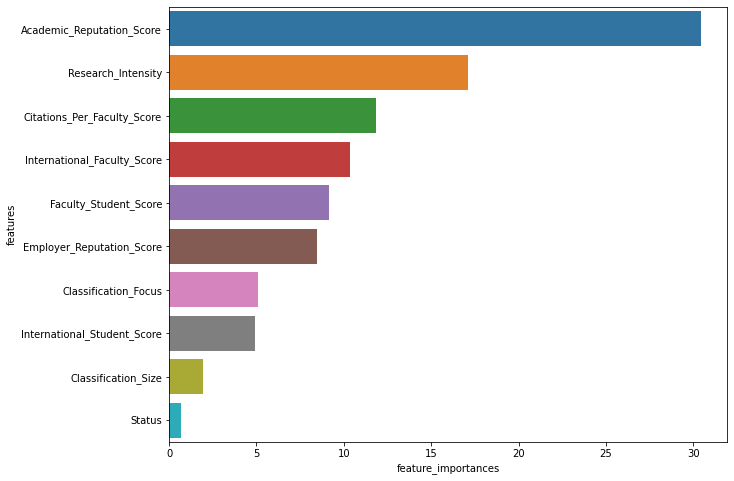

In [27]:
plot_importances(xtrain.columns, cbt.feature_importances_)

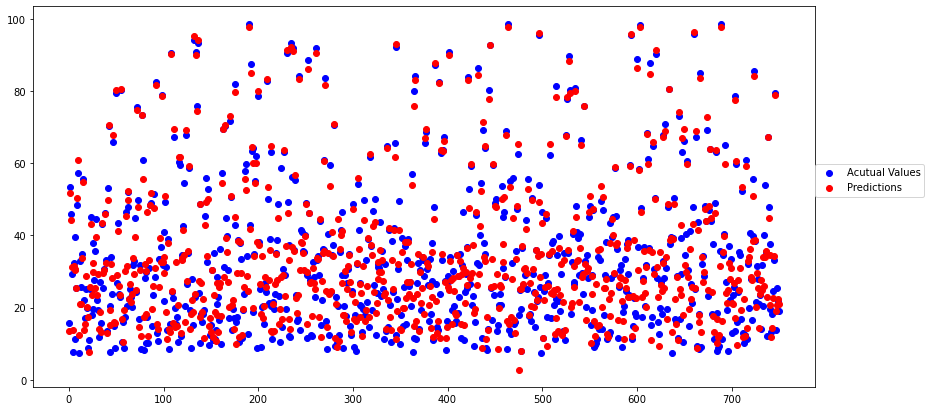

In [31]:
fig, ax = plt.subplots(figsize = (14,7))
x = np.arange(0, len(xtest), 1)
ax.scatter(x, ytest, c='b', label="Acutual Values")
ax.scatter(x, cbt.predict(xtest), c='r', label="Predictions")
ax.legend(loc=(1, 0.5));

C:\Users\RosaY\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Overall_Score', ylabel='Overall_Score'>

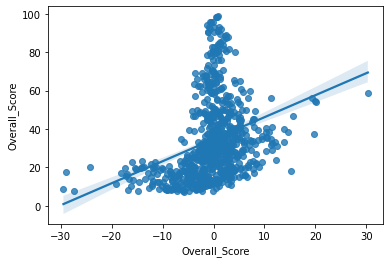

In [35]:
#residuals = ytest - cbt.predict(xtest)
sns.regplot(residuals, ytest)

# Pipeline creation - a custom transformer for the column 
The pipeline just contains to steps, 

In [48]:
class encode_columns(BaseEstimator, TransformerMixin):
    def __init__(self, columns = None):
        self.columns = columns
    
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        cols_to_transform = list(X.columns)
        if self.columns:
            cols_to_transform  = self.columns
        encoding = {
            'Classification_Size' : {
                'XL' : 1,
                'L' : 2,
                'M' : 3,
                'S' : 4},
            'Research_Intensity' : {
                'VH' : 1,
                'HI' : 2,
                'MD' : 3,
                'LO' : 4},
            'Status' : {
                'A' : 1,
                'B' : 2,
                'C' : 3}
            }
        for col in cols_to_transform:
            if col not in list(encoding.keys()):
                val_dict = {v: i for i, v in enumerate(np.unique(data[col]))}
                #print(val_dict)
            else:
                val_dict = encoding[col]
            X[col] = X[col].map(val_dict)
        return X

In [49]:
list(cat_cols)

['Classification_Size', 'Classification_Focus', 'Research_Intensity', 'Status']

In [55]:
process = [('encode columns', encode_columns(columns = list(cat_cols))), ('model', CatBoostRegressor())]
pipeline = Pipeline(process)

In [56]:
pipeline.fit(xtest, ytest)

C:\Users\RosaY\AppData\Local\Temp/ipykernel_3536/2226193550.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].map(val_dict)


{'CO': 0, 'FC': 1, 'FO': 2, 'SP': 3}
Learning rate set to 0.039132
0:	learn: 20.8238989	total: 13ms	remaining: 12.9s
1:	learn: 20.3103042	total: 25.3ms	remaining: 12.6s
2:	learn: 19.8146743	total: 64.4ms	remaining: 21.4s
3:	learn: 19.3489585	total: 91.3ms	remaining: 22.7s
4:	learn: 18.8992022	total: 104ms	remaining: 20.7s
5:	learn: 18.5080277	total: 115ms	remaining: 19s
6:	learn: 18.0790834	total: 124ms	remaining: 17.6s
7:	learn: 17.6605591	total: 135ms	remaining: 16.7s
8:	learn: 17.2561632	total: 144ms	remaining: 15.9s
9:	learn: 16.9000980	total: 154ms	remaining: 15.2s
10:	learn: 16.5468707	total: 163ms	remaining: 14.7s
11:	learn: 16.1788998	total: 172ms	remaining: 14.2s
12:	learn: 15.8543309	total: 182ms	remaining: 13.8s
13:	learn: 15.5329169	total: 194ms	remaining: 13.6s
14:	learn: 15.2608767	total: 204ms	remaining: 13.4s
15:	learn: 14.9336597	total: 224ms	remaining: 13.8s
16:	learn: 14.6491169	total: 241ms	remaining: 13.9s
17:	learn: 14.3837321	total: 251ms	remaining: 13.7s
18:	lea

175:	learn: 6.3706716	total: 1.86s	remaining: 8.72s
176:	learn: 6.3623841	total: 1.87s	remaining: 8.71s
177:	learn: 6.3588843	total: 1.88s	remaining: 8.7s
178:	learn: 6.3476493	total: 1.89s	remaining: 8.68s
179:	learn: 6.3412678	total: 1.9s	remaining: 8.67s
180:	learn: 6.3247729	total: 1.91s	remaining: 8.65s
181:	learn: 6.3149559	total: 1.92s	remaining: 8.64s
182:	learn: 6.3055901	total: 1.93s	remaining: 8.63s
183:	learn: 6.2980467	total: 1.94s	remaining: 8.61s
184:	learn: 6.2882684	total: 1.95s	remaining: 8.6s
185:	learn: 6.2777135	total: 1.96s	remaining: 8.58s
186:	learn: 6.2658290	total: 1.97s	remaining: 8.56s
187:	learn: 6.2473561	total: 1.98s	remaining: 8.55s
188:	learn: 6.2336745	total: 1.99s	remaining: 8.53s
189:	learn: 6.2185684	total: 2s	remaining: 8.52s
190:	learn: 6.2058412	total: 2.01s	remaining: 8.51s
191:	learn: 6.1890896	total: 2.02s	remaining: 8.5s
192:	learn: 6.1701116	total: 2.04s	remaining: 8.52s
193:	learn: 6.1645356	total: 2.05s	remaining: 8.51s
194:	learn: 6.15639

340:	learn: 5.0373878	total: 4.32s	remaining: 8.35s
341:	learn: 5.0290224	total: 4.34s	remaining: 8.36s
342:	learn: 5.0231073	total: 4.36s	remaining: 8.36s
343:	learn: 5.0127545	total: 4.39s	remaining: 8.36s
344:	learn: 5.0120267	total: 4.4s	remaining: 8.36s
345:	learn: 5.0029852	total: 4.42s	remaining: 8.36s
346:	learn: 4.9989847	total: 4.44s	remaining: 8.36s
347:	learn: 4.9951110	total: 4.46s	remaining: 8.35s
348:	learn: 4.9899952	total: 4.47s	remaining: 8.35s
349:	learn: 4.9867803	total: 4.49s	remaining: 8.34s
350:	learn: 4.9828811	total: 4.51s	remaining: 8.35s
351:	learn: 4.9746709	total: 4.54s	remaining: 8.35s
352:	learn: 4.9690727	total: 4.56s	remaining: 8.36s
353:	learn: 4.9634917	total: 4.57s	remaining: 8.34s
354:	learn: 4.9528332	total: 4.58s	remaining: 8.33s
355:	learn: 4.9449067	total: 4.59s	remaining: 8.31s
356:	learn: 4.9408204	total: 4.61s	remaining: 8.3s
357:	learn: 4.9322420	total: 4.62s	remaining: 8.29s
358:	learn: 4.9173193	total: 4.63s	remaining: 8.28s
359:	learn: 4.

508:	learn: 4.1332829	total: 7.41s	remaining: 7.15s
509:	learn: 4.1245704	total: 7.43s	remaining: 7.13s
510:	learn: 4.1198633	total: 7.44s	remaining: 7.12s
511:	learn: 4.1112668	total: 7.45s	remaining: 7.1s
512:	learn: 4.1072828	total: 7.47s	remaining: 7.09s
513:	learn: 4.1046676	total: 7.48s	remaining: 7.07s
514:	learn: 4.1026525	total: 7.51s	remaining: 7.08s
515:	learn: 4.1018497	total: 7.53s	remaining: 7.06s
516:	learn: 4.0959087	total: 7.54s	remaining: 7.04s
517:	learn: 4.0928179	total: 7.55s	remaining: 7.03s
518:	learn: 4.0920296	total: 7.57s	remaining: 7.01s
519:	learn: 4.0892277	total: 7.58s	remaining: 7s
520:	learn: 4.0889137	total: 7.59s	remaining: 6.98s
521:	learn: 4.0880323	total: 7.61s	remaining: 6.97s
522:	learn: 4.0877591	total: 7.63s	remaining: 6.96s
523:	learn: 4.0780122	total: 7.65s	remaining: 6.95s
524:	learn: 4.0703304	total: 7.67s	remaining: 6.94s
525:	learn: 4.0628267	total: 7.69s	remaining: 6.93s
526:	learn: 4.0558007	total: 7.7s	remaining: 6.91s
527:	learn: 4.044

678:	learn: 3.4546311	total: 9.7s	remaining: 4.58s
679:	learn: 3.4525351	total: 9.71s	remaining: 4.57s
680:	learn: 3.4483396	total: 9.71s	remaining: 4.55s
681:	learn: 3.4453582	total: 9.72s	remaining: 4.53s
682:	learn: 3.4400349	total: 9.73s	remaining: 4.52s
683:	learn: 3.4379952	total: 9.74s	remaining: 4.5s
684:	learn: 3.4315405	total: 9.75s	remaining: 4.49s
685:	learn: 3.4288606	total: 9.76s	remaining: 4.47s
686:	learn: 3.4207856	total: 9.78s	remaining: 4.45s
687:	learn: 3.4166154	total: 9.79s	remaining: 4.44s
688:	learn: 3.4135571	total: 9.8s	remaining: 4.42s
689:	learn: 3.4112265	total: 9.81s	remaining: 4.41s
690:	learn: 3.4077625	total: 9.82s	remaining: 4.39s
691:	learn: 3.4064280	total: 9.82s	remaining: 4.37s
692:	learn: 3.4036140	total: 9.83s	remaining: 4.36s
693:	learn: 3.4017555	total: 9.84s	remaining: 4.34s
694:	learn: 3.4008307	total: 9.85s	remaining: 4.32s
695:	learn: 3.4000395	total: 9.86s	remaining: 4.31s
696:	learn: 3.3902236	total: 9.87s	remaining: 4.29s
697:	learn: 3.3

855:	learn: 2.8705449	total: 11.7s	remaining: 1.97s
856:	learn: 2.8675881	total: 11.8s	remaining: 1.96s
857:	learn: 2.8648898	total: 11.8s	remaining: 1.95s
858:	learn: 2.8619581	total: 11.8s	remaining: 1.93s
859:	learn: 2.8588664	total: 11.8s	remaining: 1.92s
860:	learn: 2.8554012	total: 11.8s	remaining: 1.9s
861:	learn: 2.8496151	total: 11.8s	remaining: 1.89s
862:	learn: 2.8484562	total: 11.8s	remaining: 1.88s
863:	learn: 2.8436680	total: 11.8s	remaining: 1.86s
864:	learn: 2.8412511	total: 11.8s	remaining: 1.85s
865:	learn: 2.8402163	total: 11.8s	remaining: 1.83s
866:	learn: 2.8391533	total: 11.9s	remaining: 1.82s
867:	learn: 2.8326972	total: 11.9s	remaining: 1.8s
868:	learn: 2.8302285	total: 11.9s	remaining: 1.79s
869:	learn: 2.8272347	total: 11.9s	remaining: 1.77s
870:	learn: 2.8221471	total: 11.9s	remaining: 1.76s
871:	learn: 2.8203614	total: 11.9s	remaining: 1.75s
872:	learn: 2.8190871	total: 11.9s	remaining: 1.73s
873:	learn: 2.8143356	total: 11.9s	remaining: 1.72s
874:	learn: 2.

Pipeline(steps=[('encode columns',
                 encode_columns(columns=['Classification_Size',
                                         'Classification_Focus',
                                         'Research_Intensity', 'Status'])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x000001C7EE9CC910>)])

In [57]:
evaluate(ytest, pipeline.predict(xtest))

{'CO': 0, 'FC': 1, 'FO': 2, 'SP': 3}
MAE - 1.8182851926709689
RMSE - 2.485651938370035
R2 - 0.9864804970270394


C:\Users\RosaY\AppData\Local\Temp/ipykernel_3536/2226193550.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].map(val_dict)


(1.8182851926709689, 2.485651938370035, 0.9864804970270394)

In [22]:
import pickle as pk
with open('final_model.pickle', 'wb') as f:
    pk.dump(cbt, f)